In [1]:
from tidyverse.dummy import *
import scanpy as sc
from ecm_tools import plot_gene
import sys
sys.path.append('/users/mstrasse/CRUK-code/')
sys.path.append('/users/mstrasse/McGill_analysis/Atlas_revision/')
plt.rcParams["figure.figsize"] = (4,3)

import decoupler as dc
from IPython.display import set_matplotlib_formats
from crukiopy.colormaps import color_dict_coarse_celltype, color_dict_diagnosis
from ecm_de_data import load_ECM_M_vs_T, load_ECM_NE_vs_M, load_ECM_NE_vs_T, cmap_updown

plt.ion()

import sys
sys.path.append('..')
from util import load_merged_data

Importing tidyverse


In [2]:
plotfolder = '/tmp/ECM_NE_vs_T'
import os
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

In [3]:
df_NE_vs_T =load_ECM_NE_vs_T()
df_NE_vs_T['Pvalue_clipped'] = np.clip(df_NE_vs_T['Pvalue'] , 1e-50,  1)

In [4]:
df_NE_vs_T.query('qvalue<0.001 and log2fc < -0.58').shape

(55, 8)

In [5]:
df_NE_vs_T.query('qvalue<0.001 and log2fc > 0.58').shape

(43, 8)

## Volcano plots

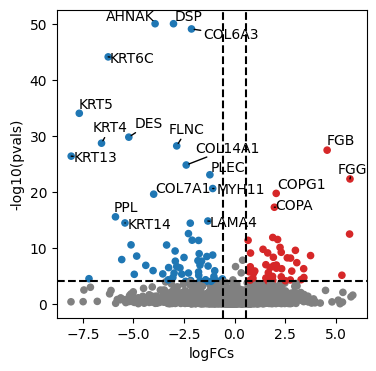

In [6]:
dc.plot_volcano_df(
    df_NE_vs_T.set_index('gene'), x='log2fc', y='Pvalue_clipped', 
    sign_thr=0.0001,
    lFCs_thr=0.58, top=20, 
    # lFCs_limit=7.5, 
    figsize=(4,4), save=f'{plotfolder}/volcano.svg')

In [7]:
df_NE_vs_T.query('(log2fc<-0.58 or log2fc>0.58) and Pvalue<0.0001')

log2fc        qvalue     gene Comparison (group1/group2)  # of Ratios  \
20      3.29  7.710000e-04    IGHA2               Tumor / AdjN           80   
23     -5.42  2.670000e-13    KRT14               Tumor / AdjN          228   
26      5.69  2.220000e-11      FGA               Tumor / AdjN          264   
32     -2.86  5.270000e-06    ANXA1               Tumor / AdjN          124   
47      2.83  2.950000e-05     PFN1               Tumor / AdjN           68   
...      ...           ...      ...                        ...          ...   
4298   -2.61  9.050000e-05     DSC2               Tumor / AdjN           44   
4331   -1.02  2.240000e-04   SPTBN2               Tumor / AdjN           36   
4496   -7.20  5.220000e-04    KRT15               Tumor / AdjN           24   
4946   -1.78  4.050000e-05      NES               Tumor / AdjN           36   
5498   -3.55  8.390000e-05  S100A16               Tumor / AdjN           12   

            Pvalue up_or_down  Pvalue_clipped  
20    5.140000e-05         up    5.140000e-05  
23    3.790000e-15       down    3.790000e-15  
26    3.630000e-13         up    3.630000e-13  
32    2.240000e-07       down    2.240000e-07  
47    1.500000e-06         up    1.500000e-06  
...            ...        ...             ...  
4298  5.200000e-06       down    5.200000e-06  
4331  1.370000e-05       down    1.370000e-05  
4496  3.400000e-05       down    3.400000e-05  
4946  2.120000e-06       down    2.120000e-06  
5498  4.760000e-06       down    4.760000e-06  

[104 rows x 8 columns]

# scRNAseq

In [8]:
ECM_patients = ['E07', 'E14','E20','E21', 'E24','E26']
ECM_diagnosis =['NE', 'T']

/tmp/ipykernel_4181111/2633978143.py:4: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.


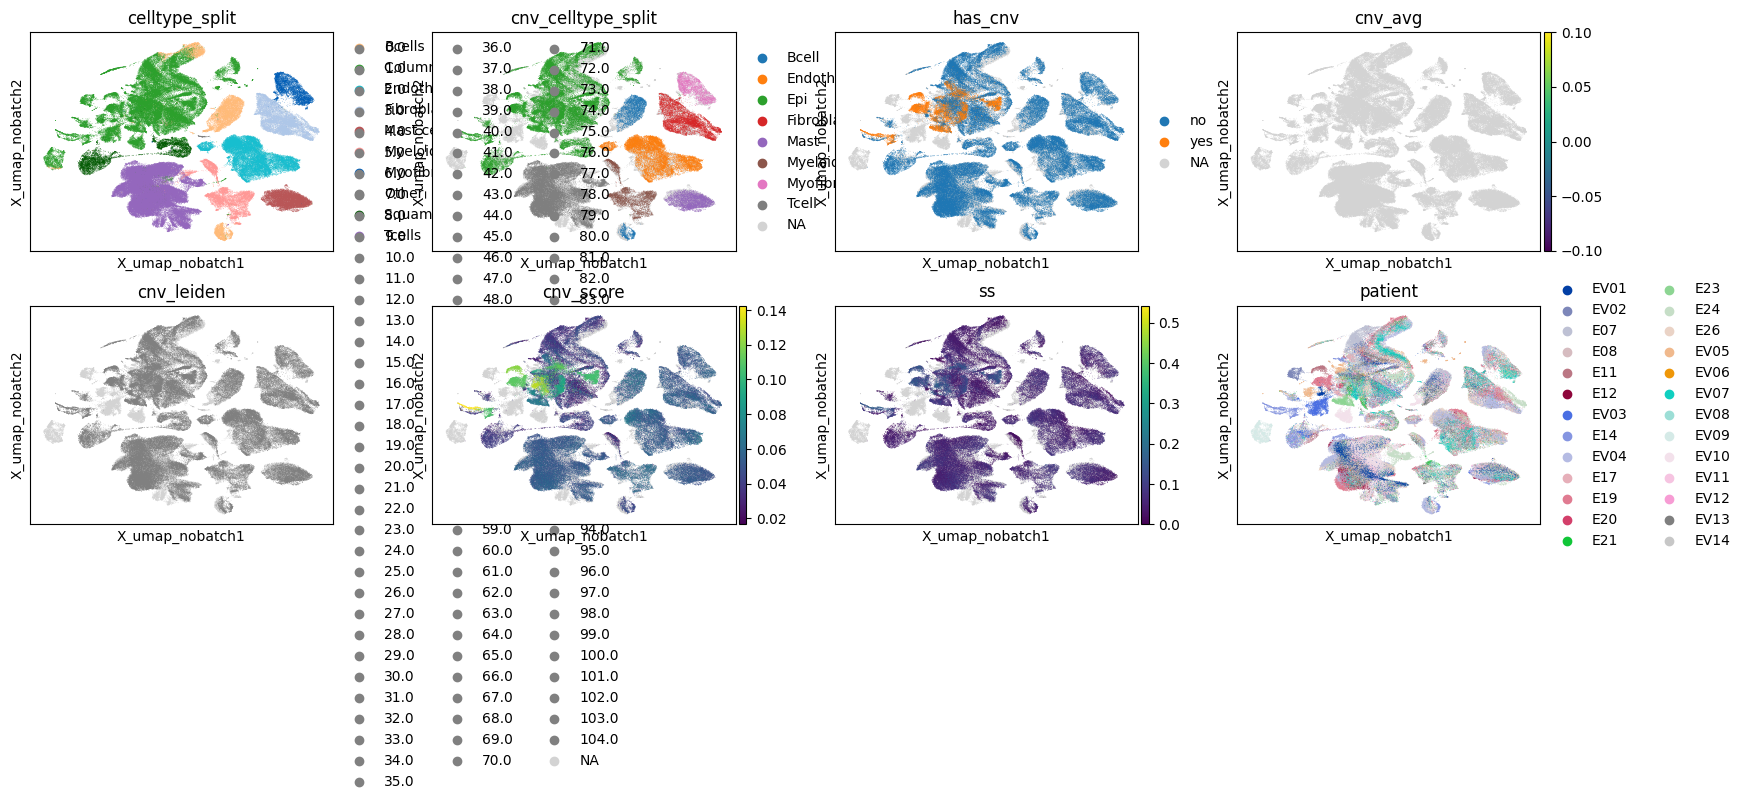

In [9]:
A = load_merged_data()

# add CNV calls
df_cnv = pd.read_csv('/users/mstrasse/CRUK-code/notebooks/CNVs/O_full.csv', index_col=0)
A.obs.index = A.obs.index.map(lambda x: '-'.join(x.split('-')[:2]))
A.obs = A.obs.merge(df_cnv[['cnv_celltype_split','has_cnv','cnv_avg','cnv_leiden', 'cnv_score', 'ss']], left_index=True, right_index=True, how='left')
A.obs.cnv_leiden = pd.Categorical(A.obs.cnv_leiden)

sc.pl.embedding(A, basis='X_umap_nobatch', color=['celltype_split', 'cnv_celltype_split', 'has_cnv','cnv_avg','cnv_leiden', 'cnv_score', 'ss', 'patient'])

In [10]:
A = A[A.obs.patient.isin(ECM_patients)]
A = A[A.obs.diagnosis.isin(ECM_diagnosis)].copy()
A.raw = A

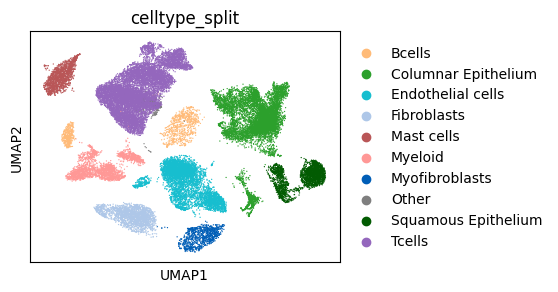

In [11]:
sc.pl.umap(A, color='celltype_split')

In [12]:
import gc
gc.collect()

57540

In [13]:
cluster_order = [
    'Columnar Epithelium', 
    'Squamous Epithelium',
    'Bcells', 
    'Tcells',
    'Mast cells', 
    'Myeloid',
    'Endothelial cells', 
    'Fibroblasts',
    'Myofibroblasts',
    'Other'
]

A.obs.celltype_split = pd.Categorical(A.obs.celltype_split, cluster_order)

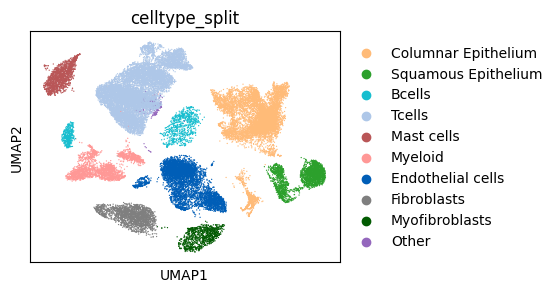

In [14]:
sc.pl.umap(A, color='celltype_split')

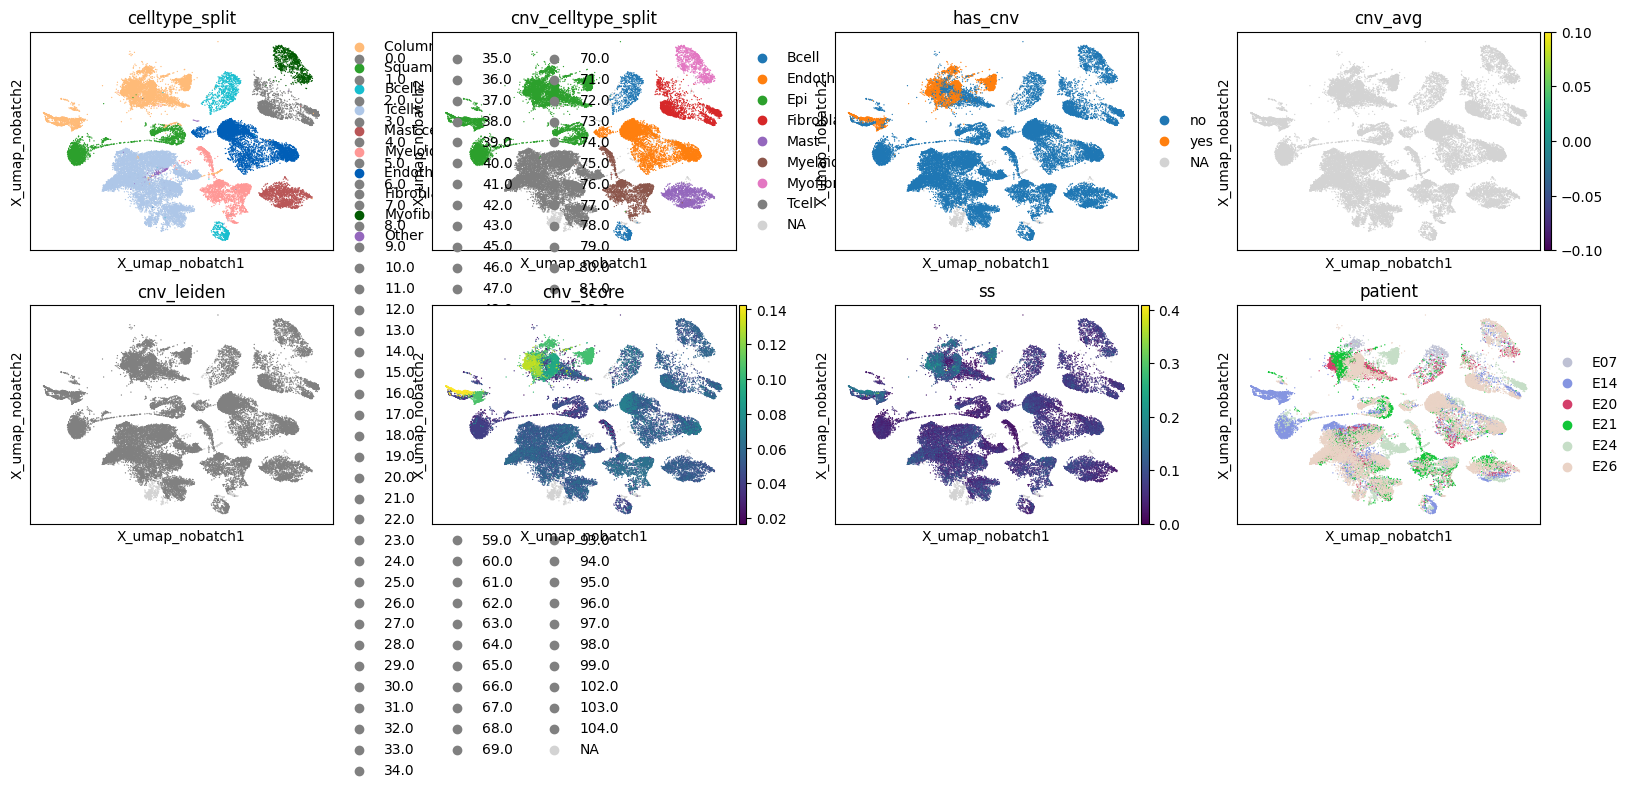

In [15]:
sc.pl.embedding(A, basis='X_umap_nobatch', color=['celltype_split', 'cnv_celltype_split', 'has_cnv','cnv_avg','cnv_leiden', 'cnv_score', 'ss', 'patient'])

In [16]:
A.obs['celltype_split_cnv_augmented'] = A.obs['celltype_split'].astype(str)
A.obs.loc[A.obs.query('celltype_split=="Columnar Epithelium" and has_cnv=="yes"').index, 'celltype_split_cnv_augmented'] = "Columnar Epithelium (CNV+)"
A.obs.loc[A.obs.query('celltype_split=="Columnar Epithelium" and has_cnv=="no"').index, 'celltype_split_cnv_augmented'] = "Columnar Epithelium (CNV-)"

_c = ['Columnar Epithelium (CNV-)', 'Columnar Epithelium (CNV+)', 'Squamous Epithelium', 'Bcells', 'Tcells', 'Mast cells', 'Myeloid', 'Endothelial cells', 'Fibroblasts',  'Myofibroblasts', 'Other']
A.obs.celltype_split_cnv_augmented = pd.Categorical(A.obs.celltype_split_cnv_augmented, _c) 

pd.crosstab(A.obs.celltype_split_cnv_augmented, A.obs.has_cnv)

has_cnv                          no   yes
celltype_split_cnv_augmented             
Columnar Epithelium (CNV-)     2185     0
Columnar Epithelium (CNV+)        0  5546
Squamous Epithelium            2632    17
Bcells                         1043     0
Tcells                        10231     0
Mast cells                     1488     0
Myeloid                        2228     0
Endothelial cells              5046     0
Fibroblasts                    1999     0
Myofibroblasts                  949     0
Other                           118     0

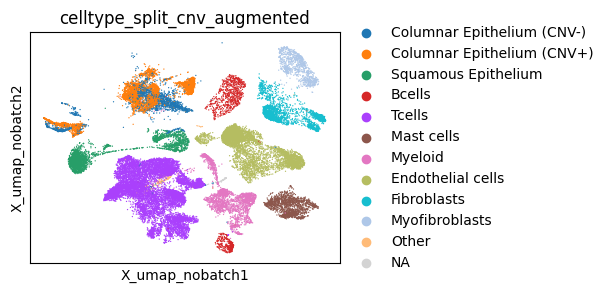

In [17]:
sc.pl.embedding(A, basis='X_umap_nobatch', color=['celltype_split_cnv_augmented'])

# NE vs T differential expression

In [18]:
genes_up = sorted(df_NE_vs_T.query('qvalue<0.001 and log2fc>0.58').gene.values)
genes_down = sorted(df_NE_vs_T.query('qvalue<0.001 and log2fc<-0.58').gene.values)

## ECM-DE vs cell types

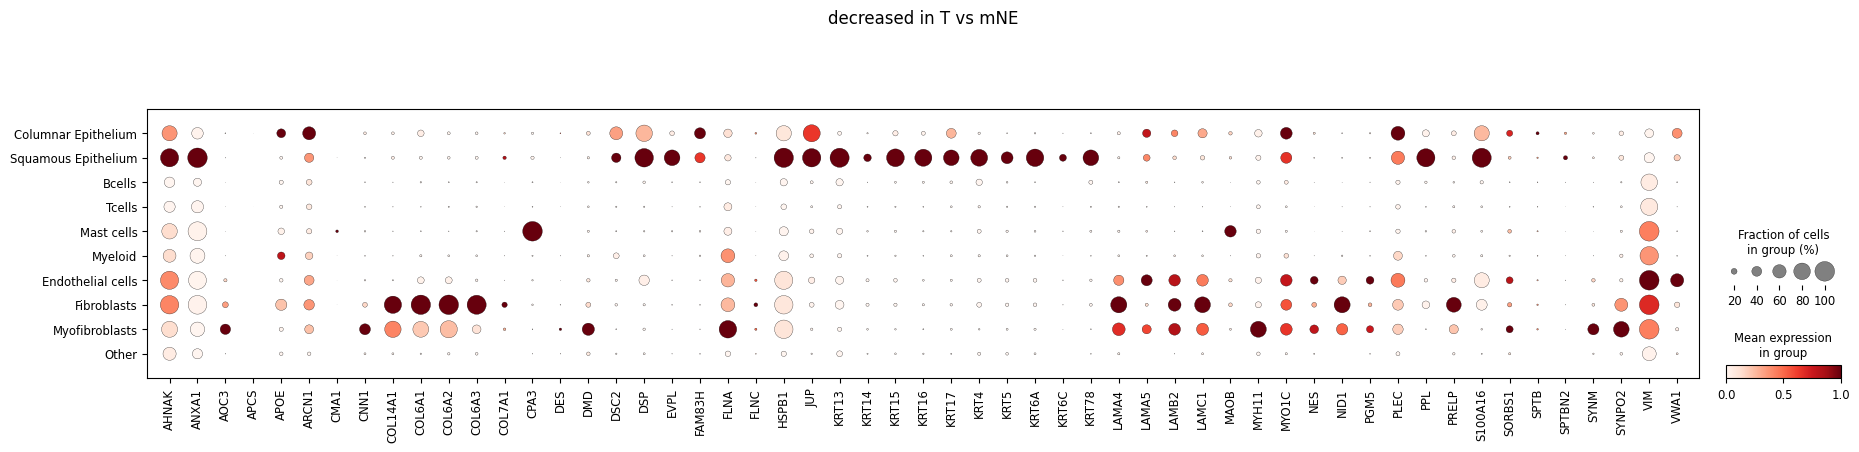

In [19]:
sc.pl.dotplot(A, var_names=genes_down, groupby='celltype_split', standard_scale='var', dendrogram=False, show=False, title='decreased in T vs mNE');
plt.savefig(f'{plotfolder}/ECM_singlecellsource_downreg.svg')

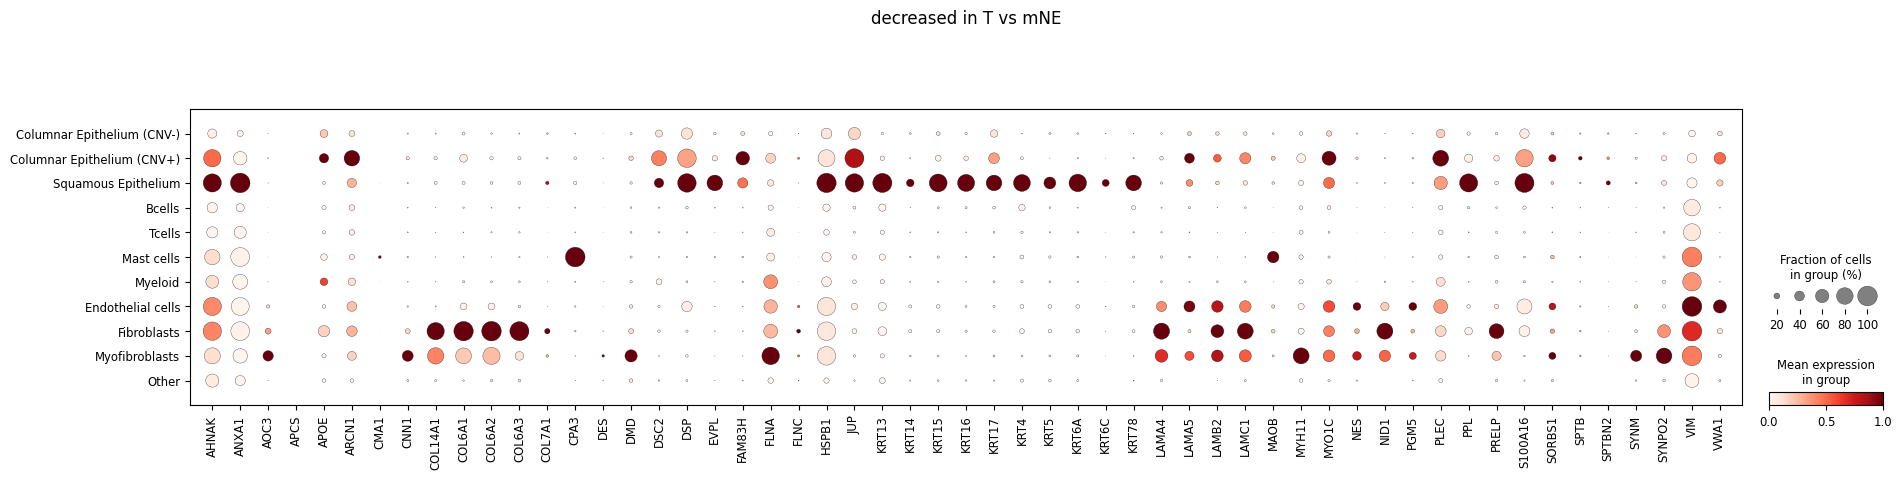

In [20]:
sc.pl.dotplot(A, var_names=genes_down, groupby='celltype_split_cnv_augmented', standard_scale='var', dendrogram=False, show=False, title='decreased in T vs mNE');
plt.savefig(f'{plotfolder}/ECM_singlecellsource_downreg_cnv_aug.svg')

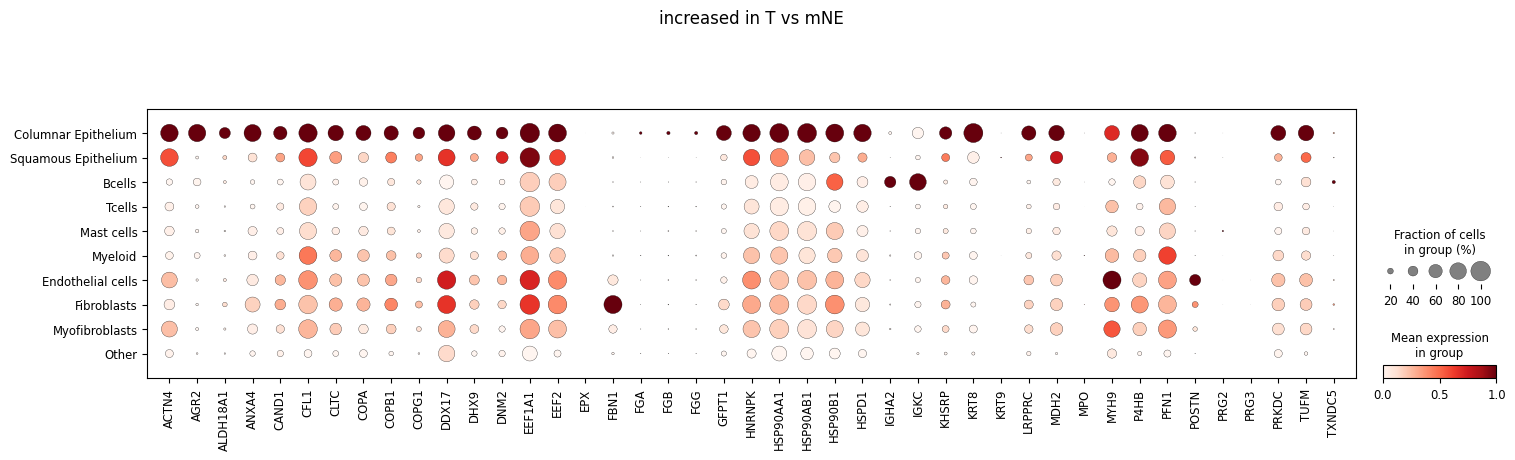

In [21]:
sc.pl.dotplot(A, var_names=genes_up, groupby='celltype_split', standard_scale='var', dendrogram=False, show=False, title='increased in T vs mNE');
plt.savefig(f'{plotfolder}/ECM_singlecellsource_upreg.svg')

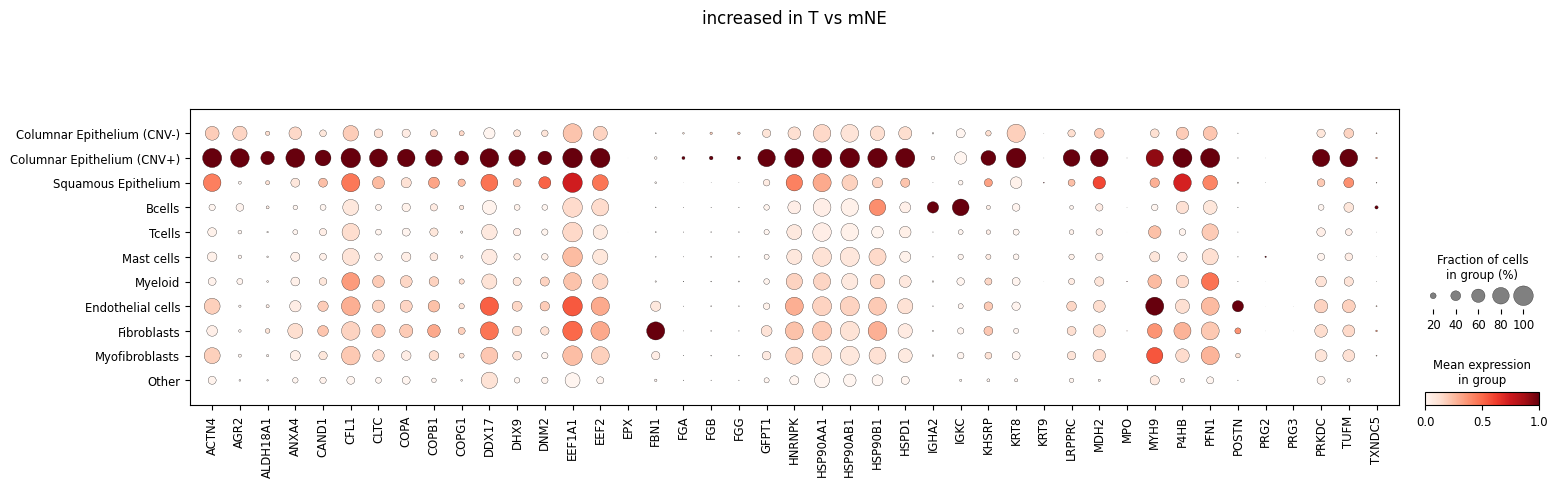

In [22]:
sc.pl.dotplot(A, var_names=genes_up, groupby='celltype_split_cnv_augmented', standard_scale='var', dendrogram=False, show=False, title='increased in T vs mNE');
plt.savefig(f'{plotfolder}/ECM_singlecellsource_upreg_cnv_aug.svg')

In [23]:
_d = A.obs.groupby(['celltype_split_cnv_augmented','diagnosis']).samplename.count().reset_index().rename({'samplename': 'n_cells'}, axis=1)
celltype_total = _d .groupby('celltype_split_cnv_augmented').n_cells.sum().to_dict()
_d['total'] = _d.celltype_split_cnv_augmented.apply(lambda x: celltype_total[x]).astype(int)
_d['percent_cells'] = _d.n_cells / _d.total
# reverse order so it works in the flipped diagram
_d['celltype_split_cnv_augmented'] = pd.Categorical(_d['celltype_split_cnv_augmented'] , _d['celltype_split_cnv_augmented'].cat.categories[::-1])
_d.head()

celltype_split_cnv_augmented diagnosis  n_cells  total  percent_cells
0   Columnar Epithelium (CNV-)        NE      112   2185       0.051259
1   Columnar Epithelium (CNV-)         T     2073   2185       0.948741
2   Columnar Epithelium (CNV+)        NE        0   5546       0.000000
3   Columnar Epithelium (CNV+)         T     5546   5546       1.000000
4          Squamous Epithelium        NE     2627   2649       0.991695

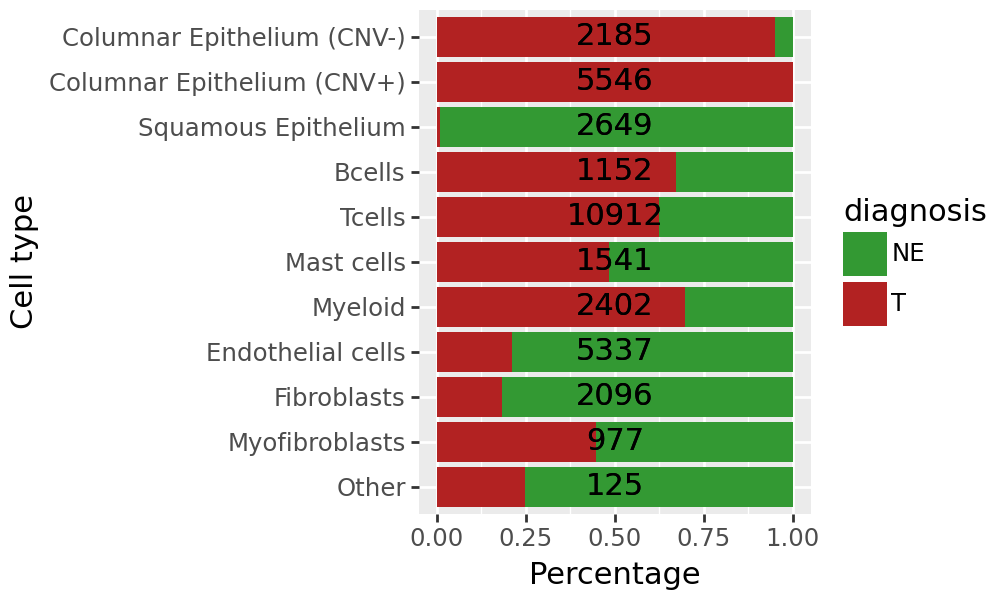

In [24]:
pn.ggplot(_d) +pn.aes(x='celltype_split_cnv_augmented', fill='diagnosis', y='percent_cells') + pn.geom_bar(stat='identity') \
+ pn.geom_text(data=_d, mapping=pn.aes( x='celltype_split_cnv_augmented', y=0.5, label='total')) \
+ pn.coord_flip()+pn.theme(figure_size=(5,3)) + pn.labs(y='Percentage', x='Cell type') + pn.scale_fill_manual(color_dict_diagnosis)

# General fold change in proteomics vs scrnaseq 
independent of cell type etc

In [25]:
from ecm_tools import fold_change_pseudobulk_fixed
adata_bulk_de = dc.get_pseudobulk(
        A,
        sample_col='samplename', 
        groups_col=None,
        use_raw=False,
        mode='sum',
        min_cells=0,
        # min_counts=10000,
    )
adata_bulk_de.raw  = adata_bulk_de

In [26]:
_FC_pseudobulk_df =  fold_change_pseudobulk_fixed(adata_bulk_de, gene_list=genes_up+genes_down, diagnosis1="NE", diagnosis2="T")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [00:00<00:00, 168.05it/s]


/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_FC_comparison.svg


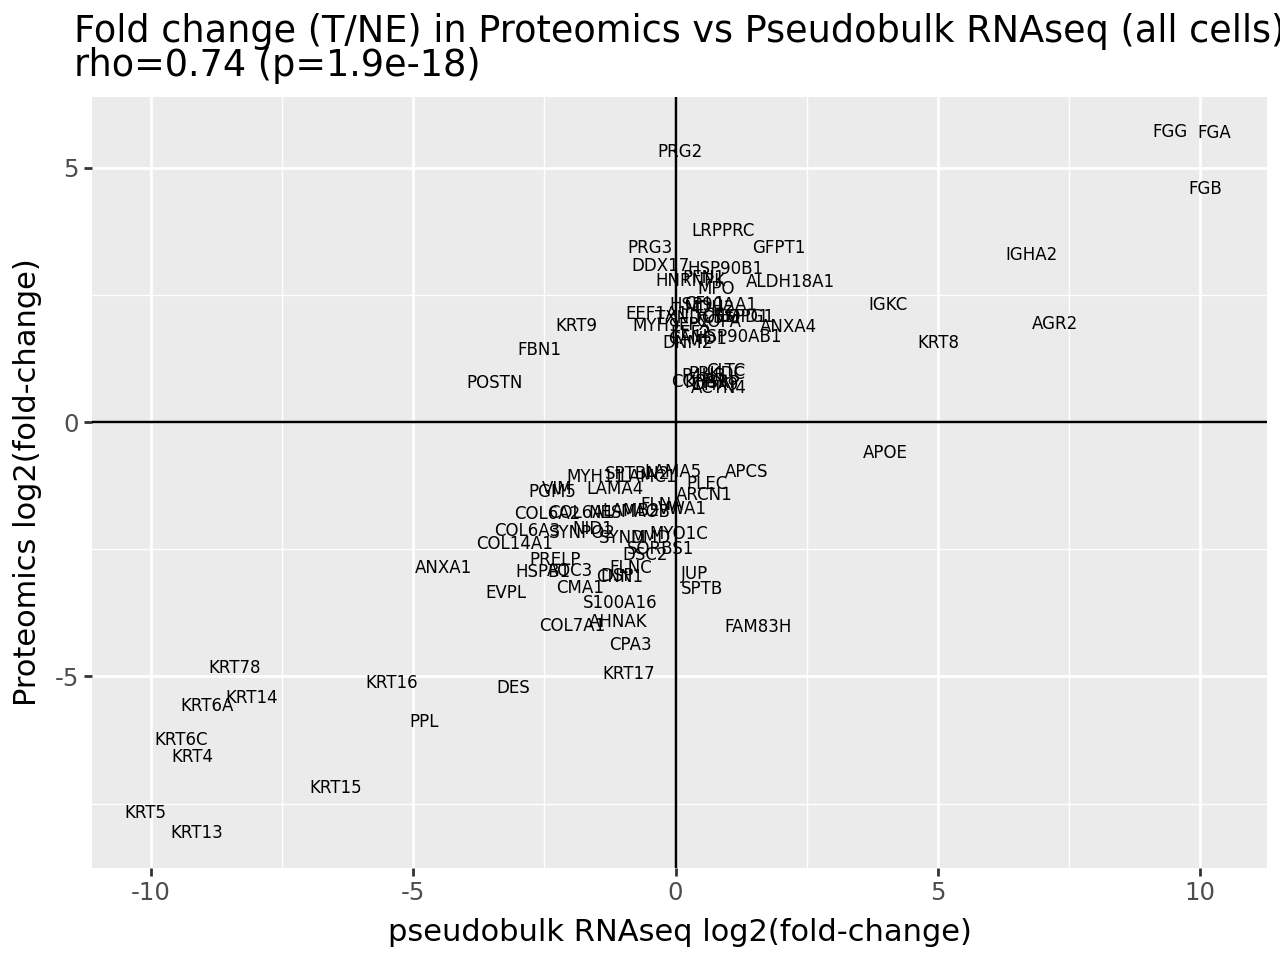

In [27]:
df_FC_sc_proteomics = _FC_pseudobulk_df\
 .merge(df_NE_vs_T.rename({'log2fc': 'log2fc_proteomics', 'qvalue': 'qvalue_proteomics'}, axis=1), on='gene')#\
 #.query('gene not in ["FGA","FGG","FGB"]')

from scipy.stats import spearmanr
rho, pval_rho = spearmanr(
    np.log2(df_FC_sc_proteomics.ratio_scrnaseq),
    df_FC_sc_proteomics.log2fc_proteomics)


p = pn.ggplot(df_FC_sc_proteomics,
          pn.aes('np.log2(ratio_scrnaseq)', 'log2fc_proteomics', label='gene' ))\
+ pn.geom_text(size=6) + pn.geom_vline(xintercept=0) + pn.geom_hline(yintercept=0)\
+ pn.labs(title=f'Fold change (T/NE) in Proteomics vs Pseudobulk RNAseq (all cells)\nrho={rho:.2f} (p={pval_rho:.1e})', x='pseudobulk RNAseq log2(fold-change)', y='Proteomics log2(fold-change)')
p.save(f'{plotfolder}/ECM_FC_comparison.svg')
p

In [28]:
df_FC_sc_proteomics.query('gene=="POSTN"')

index  delta_expression_scrnaseq  NE_expression_scrnaseq  \
37     37                 -1607972.0               1771317.0   

    T_expression_scrnaseq  ratio_scrnaseq   gene  log2fc_proteomics  \
37               163345.0        0.092217  POSTN               0.78   

    qvalue_proteomics Comparison (group1/group2)  # of Ratios        Pvalue  \
37           0.000006               Tumor / AdjN          228  2.530000e-07   

   up_or_down  Pvalue_clipped  
37         up    2.530000e-07

### Filter the Fibrinogens

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_FC_comparison_filtered_fga.svg


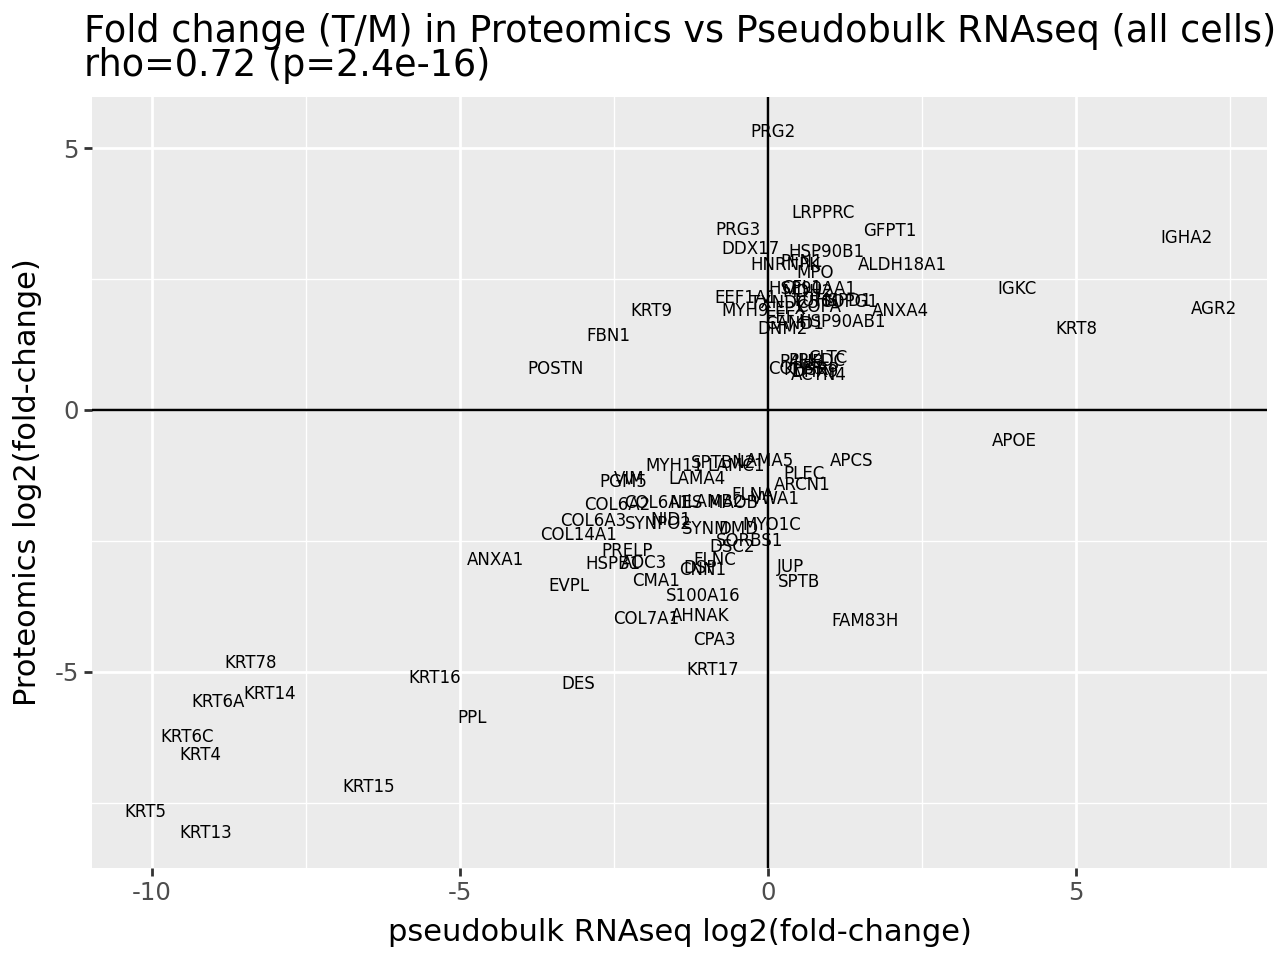

In [29]:
df_FC_sc_proteomics = _FC_pseudobulk_df\
 .merge(df_NE_vs_T.rename({'log2fc': 'log2fc_proteomics', 'qvalue': 'qvalue_proteomics'}, axis=1), on='gene') \
 .query('gene not in ["FGA","FGG","FGB"]')

from scipy.stats import spearmanr
rho, pval_rho = spearmanr(
    np.log2(df_FC_sc_proteomics.ratio_scrnaseq),
    df_FC_sc_proteomics.log2fc_proteomics)


p = pn.ggplot(df_FC_sc_proteomics,
          pn.aes('np.log2(ratio_scrnaseq)', 'log2fc_proteomics', label='gene' ))\
+ pn.geom_text(size=6) + pn.geom_vline(xintercept=0) + pn.geom_hline(yintercept=0)\
+ pn.labs(title=f'Fold change (T/M) in Proteomics vs Pseudobulk RNAseq (all cells)\nrho={rho:.2f} (p={pval_rho:.1e})', x='pseudobulk RNAseq log2(fold-change)', y='Proteomics log2(fold-change)')
p.save(f'{plotfolder}/ECM_FC_comparison_filtered_fga.svg')
p

## Using Deseq to get FCs

In [30]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [31]:
pdata = dc.get_pseudobulk(A.raw.to_adata(),
                          sample_col='samplename',
                          groups_col='diagnosis',#'celltype_split',
                          # layer='counts',
                          mode='sum',
                          min_cells=50,
                          # min_counts=1000
                         )
sc.pp.filter_genes(pdata, min_counts=1)
pdata

AnnData object with n_obs × n_vars = 12 × 30635
    obs: 'samplename', 'diagnosis', 'patient', 'procedure', 'dataset', 'psbulk_n_cells', 'psbulk_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'is_mito', 'is_ribo', 'old_genename', 'n_counts'
    layers: 'psbulk_props'

### Actual DE

#### with patient

In [32]:
dds = DeseqDataSet(
    adata=pdata.copy(),
    design_factors=['patient','diagnosis'],
    refit_cooks=True,
    n_cpus=8,
)
dds.deseq2()

stats_res = DeseqStats(dds, contrast=["diagnosis",  "T", "NE"],)
stats_res.summary()
# stats_res.lfc_shrink(coeff='diagnosis_T_vs_M')
df_DE= stats_res.results_df


stats_res = DeseqStats(dds, contrast=["diagnosis",  "T", "NE"], )
stats_res.summary()
stats_res.lfc_shrink(coeff='diagnosis_T_vs_NE')
df_DE_shrink= stats_res.results_df

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 6.97 seconds.

Fitting dispersion trend curve...
/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
... done in 1.13 seconds.

Fitting MAP dispersions...
... done in 10.84 seconds.

Fitting LFCs...
... done in 10.44 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 3.84 seconds.



Log2 fold change & Wald test p-value: diagnosis T vs NE
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     846.668689       -0.260669  0.316446 -0.823739  4.100881e-01   
A1CF     278.250432        2.774126  0.871608  3.182767  1.458749e-03   
A2M     7095.578301       -1.457434  0.541324 -2.692348  7.095088e-03   
A2ML1   2822.790629       -4.360584  0.735807 -5.926257  3.099174e-09   
A2MP1     40.693225       -1.211300  0.654574 -1.850517  6.423913e-02   
...             ...             ...       ...       ...           ...   
ZYG11A   115.021160       -0.218916  0.238647 -0.917320  3.589748e-01   
ZYG11B  1033.622988       -0.277451  0.136018 -2.039807  4.136952e-02   
ZYX     1660.163932        0.152574  0.217311  0.702102  4.826158e-01   
ZZEF1    629.490999        0.038240  0.219647  0.174097  8.617891e-01   
ZZZ3     869.713641        0.831793  0.428917  1.939285  5.246660e-02   

                padj  
A1BG    6.313400e-01  
A1CF    1.166262e-02 

Running Wald tests...
... done in 1.99 seconds.



Log2 fold change & Wald test p-value: diagnosis T vs NE
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     846.668689       -0.260669  0.316446 -0.823739  4.100881e-01   
A1CF     278.250432        2.774126  0.871608  3.182767  1.458749e-03   
A2M     7095.578301       -1.457434  0.541324 -2.692348  7.095088e-03   
A2ML1   2822.790629       -4.360584  0.735807 -5.926257  3.099174e-09   
A2MP1     40.693225       -1.211300  0.654574 -1.850517  6.423913e-02   
...             ...             ...       ...       ...           ...   
ZYG11A   115.021160       -0.218916  0.238647 -0.917320  3.589748e-01   
ZYG11B  1033.622988       -0.277451  0.136018 -2.039807  4.136952e-02   
ZYX     1660.163932        0.152574  0.217311  0.702102  4.826158e-01   
ZZEF1    629.490999        0.038240  0.219647  0.174097  8.617891e-01   
ZZZ3     869.713641        0.831793  0.428917  1.939285  5.246660e-02   

                padj  
A1BG    6.313400e-01  
A1CF    1.166262e-02 

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: diagnosis T vs NE
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     846.668689       -0.210056  0.272899 -0.823739  4.100881e-01   
A1CF     278.250432        1.998692  1.305542  3.182767  1.458749e-03   
A2M     7095.578301       -1.186737  0.673489 -2.692348  7.095088e-03   
A2ML1   2822.790629       -4.040208  0.880695 -5.926257  3.099174e-09   
A2MP1     40.693225       -0.621876  0.578206 -1.850517  6.423913e-02   
...             ...             ...       ...       ...           ...   
ZYG11A   115.021160       -0.191170  0.216781 -0.917320  3.589748e-01   
ZYG11B  1033.622988       -0.263030  0.132148 -2.039807  4.136952e-02   
ZYX     1660.163932        0.141330  0.195218  0.702102  4.826158e-01   
ZZEF1    629.490999        0.034629  0.200454  0.174097  8.617891e-01   
ZZZ3     869.713641        0.650668  0.386440  1.939285  5.246660e-02   

                padj  
A1BG    6.313400e-01  
A1CF    1.1662

... done in 4.74 seconds.



#### wityhout patient

In [33]:
dds_diag_only = DeseqDataSet(
    adata=pdata.copy(),
    design_factors=['diagnosis'],
    refit_cooks=True,
    n_cpus=8,
)
dds_diag_only.deseq2()

stats_res_diag_only = DeseqStats(dds_diag_only, contrast=["diagnosis",  "T", "NE"])
stats_res_diag_only.summary()
# stats_res.lfc_shrink(coeff='diagnosis_T_vs_M')
df_DE_diag_only= stats_res_diag_only.results_df

stats_res_diag_only = DeseqStats(dds_diag_only, contrast=["diagnosis",  "T", "NE"])
stats_res_diag_only.summary()
stats_res_diag_only.lfc_shrink(coeff='diagnosis_T_vs_NE')
df_DE_diag_only_shrink= stats_res_diag_only.results_df

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 4.40 seconds.

Fitting dispersion trend curve...
... done in 1.08 seconds.

Fitting MAP dispersions...
... done in 6.97 seconds.

Fitting LFCs...
... done in 6.01 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 941 outlier genes.

Fitting dispersions...
... done in 0.33 seconds.

Fitting MAP dispersions...
... done in 0.33 seconds.

Fitting LFCs...
... done in 0.24 seconds.

Running Wald tests...
... done in 11.10 seconds.



Log2 fold change & Wald test p-value: diagnosis T vs NE
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     846.668689       -0.122589  0.271902 -0.450858  6.520921e-01   
A1CF     278.250432        2.710540  0.791685  3.423763  6.176052e-04   
A2M     7095.578301       -1.072224  0.500573 -2.141993  3.219407e-02   
A2ML1   2822.790629       -5.529523  0.712448 -7.761299  8.406416e-15   
A2MP1     40.693225       -1.928185  0.608754 -3.167432  1.537919e-03   
...             ...             ...       ...       ...           ...   
ZYG11A   115.021160       -0.292494  0.254083 -1.151171  2.496618e-01   
ZYG11B  1033.622988       -0.308735  0.142873 -2.160901  3.070296e-02   
ZYX     1660.163932        0.343775  0.345245  0.995742  3.193754e-01   
ZZEF1    629.490999       -0.071401  0.213523 -0.334396  7.380811e-01   
ZZZ3     869.713641        0.623102  0.425044  1.465969  1.426566e-01   

                padj  
A1BG    8.005976e-01  
A1CF    5.283115e-03 

Running Wald tests...
... done in 1.98 seconds.

Fitting MAP LFCs...


Log2 fold change & Wald test p-value: diagnosis T vs NE
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     846.668689       -0.122589  0.271902 -0.450858  6.520921e-01   
A1CF     278.250432        2.710540  0.791685  3.423763  6.176052e-04   
A2M     7095.578301       -1.072224  0.500573 -2.141993  3.219407e-02   
A2ML1   2822.790629       -5.529523  0.712448 -7.761299  8.406416e-15   
A2MP1     40.693225       -1.928185  0.608754 -3.167432  1.537919e-03   
...             ...             ...       ...       ...           ...   
ZYG11A   115.021160       -0.292494  0.254083 -1.151171  2.496618e-01   
ZYG11B  1033.622988       -0.308735  0.142873 -2.160901  3.070296e-02   
ZYX     1660.163932        0.343775  0.345245  0.995742  3.193754e-01   
ZZEF1    629.490999       -0.071401  0.213523 -0.334396  7.380811e-01   
ZZZ3     869.713641        0.623102  0.425044  1.465969  1.426566e-01   

                padj  
A1BG    8.005976e-01  
A1CF    5.283115e-03 

/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + size) / (1 + size * np.exp(-xbeta - offset))
/opt/conda/lib/python3.11/site-packages/pydeseq2/utils.py:1260: RuntimeWarning: overflow encountered in exp
  counts - (counts + s

Shrunk log2 fold change & Wald test p-value: diagnosis T vs NE
           baseMean  log2FoldChange     lfcSE      stat        pvalue  \
A1BG     846.668689       -0.000002  0.001540 -0.450858  6.520921e-01   
A1CF     278.250432        2.094278  0.880093  3.423763  6.176052e-04   
A2M     7095.578301       -0.000005  0.001317 -2.141993  3.219407e-02   
A2ML1   2822.790629       -5.332767  0.707021 -7.761299  8.406416e-15   
A2MP1     40.693225       -1.415497  0.661193 -3.167432  1.537919e-03   
...             ...             ...       ...       ...           ...   
ZYG11A   115.021160       -0.000005  0.001499 -1.151171  2.496618e-01   
ZYG11B  1033.622988       -0.000016  0.001492 -2.160901  3.070296e-02   
ZYX     1660.163932        0.000003  0.001699  0.995742  3.193754e-01   
ZZEF1    629.490999       -0.000002  0.001557 -0.334396  7.380811e-01   
ZZZ3     869.713641        0.000003  0.001811  1.465969  1.426566e-01   

                padj  
A1BG    8.005976e-01  
A1CF    5.2831

... done in 4.70 seconds.



## Plots

### Interlude
FCs are problematic to compare (shrinkage vs no-shrinkage, noisy etc).
How about a more clearcut comparison:

For all genes measured in ECM and scRNAseq:
- how many were DE in each technology and whats the overlap -> Fisher test
- of the ones that are DEG in both technologies, how many are cocordant (genes goes up in both ECM and sc, gene does doewn in both ECM and sc)?

In [34]:
from scipy.stats import fisher_exact

In [35]:
df_tmp = df_DE.merge(df_NE_vs_T.set_index('gene'), left_index=True, right_index=True)

In [36]:
threshold = 0.001
table = pd.crosstab(
    df_tmp.padj < threshold, 
    df_tmp.qvalue < threshold
)
print(fisher_exact(table))
table

SignificanceResult(statistic=2.721319018404908, pvalue=0.0002359572316724028)


qvalue  False  True 
padj                
False    1613     80
True      163     22

In [37]:
from sklearn.metrics import roc_auc_score

In [38]:
roc_auc_score(
    df_tmp.padj < threshold,
    df_tmp.qvalue < threshold
)

0.5358327612905286

In [39]:
d2 = df_tmp.query('padj < @threshold and qvalue < @threshold')

table = pd.crosstab(
    d2.log2FoldChange < 0, 
    d2.log2fc < 0
)
print(fisher_exact(table))
table

SignificanceResult(statistic=inf, pvalue=9.38174312787316e-05)


log2fc          False  True 
log2FoldChange              
False               6      0
True                1     15

In [40]:
from ecm_tools import plot_fc_comparision

#### diag+patient, unshrunkl

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_FC_comparison_unshrunk_patient_diag.svg


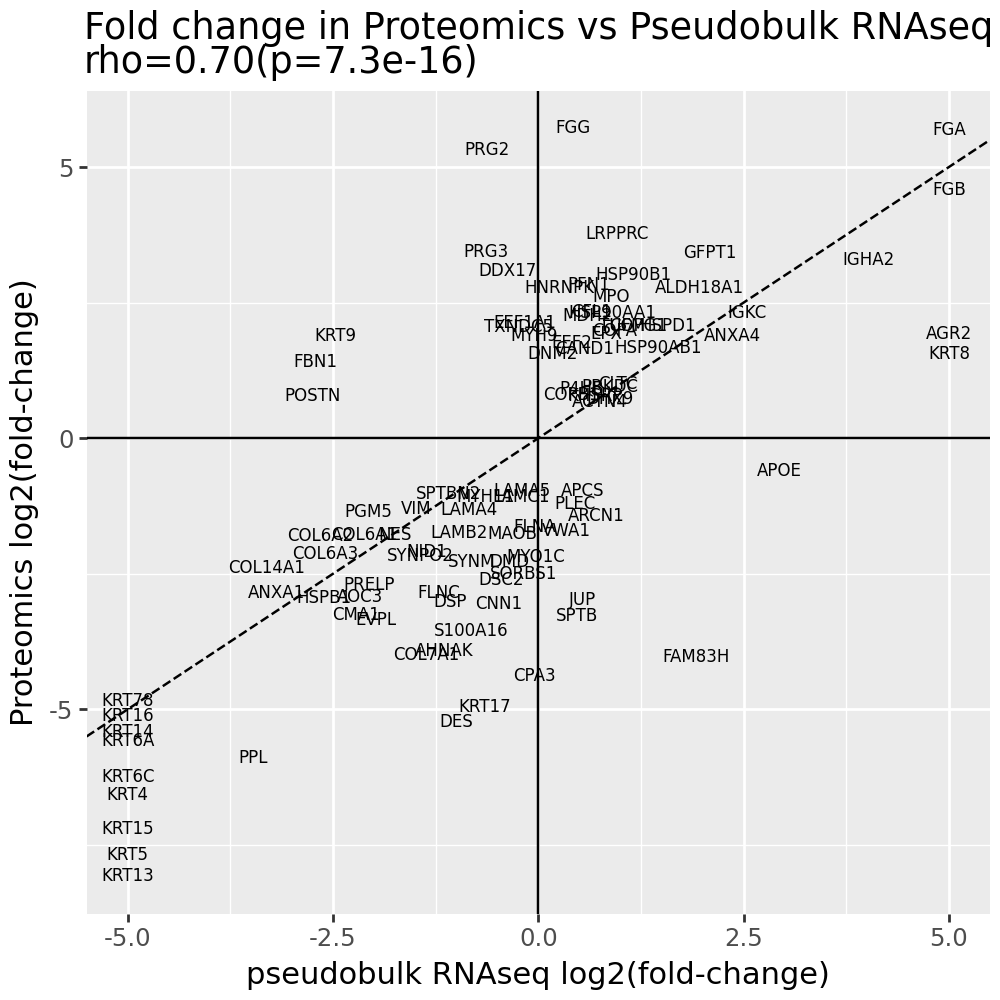

In [41]:
df = df_DE.merge(df_NE_vs_T.set_index('gene'), left_index=True, right_index=True).loc[genes_up+genes_down]
p = plot_fc_comparision(df, )+ pn.theme(figure_size=(5,5))
p.save(f'{plotfolder}/ECM_FC_comparison_unshrunk_patient_diag.svg')
p

#### patient + diag, with shrinkage

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_FC_comparison_shrunk_patient_diag.svg


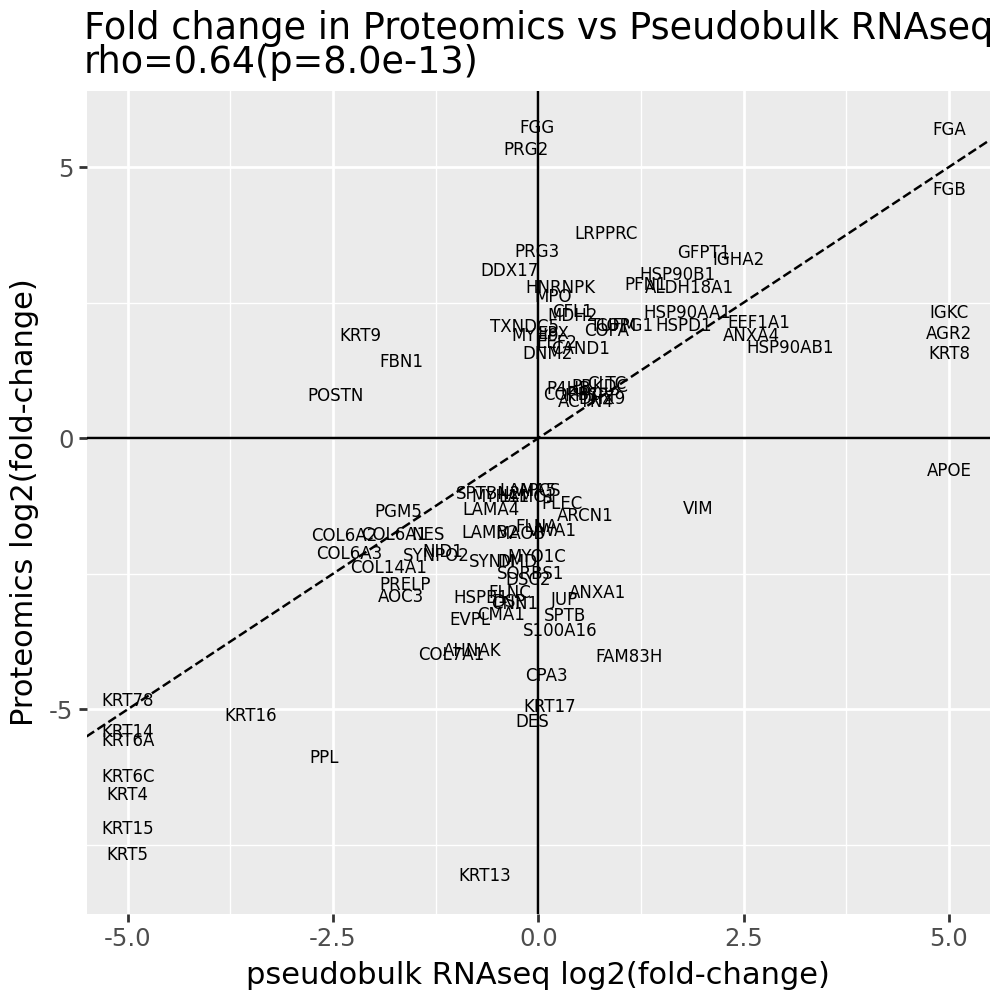

In [42]:
df = df_DE_shrink.merge(df_NE_vs_T.set_index('gene'), left_index=True, right_index=True).loc[genes_up+genes_down]
p = plot_fc_comparision(df)+ pn.theme(figure_size=(5,5))
p.save(f'{plotfolder}/ECM_FC_comparison_shrunk_patient_diag.svg')
p

#### diag, unshrunk

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_FC_comparison_unshrunk_diag.svg


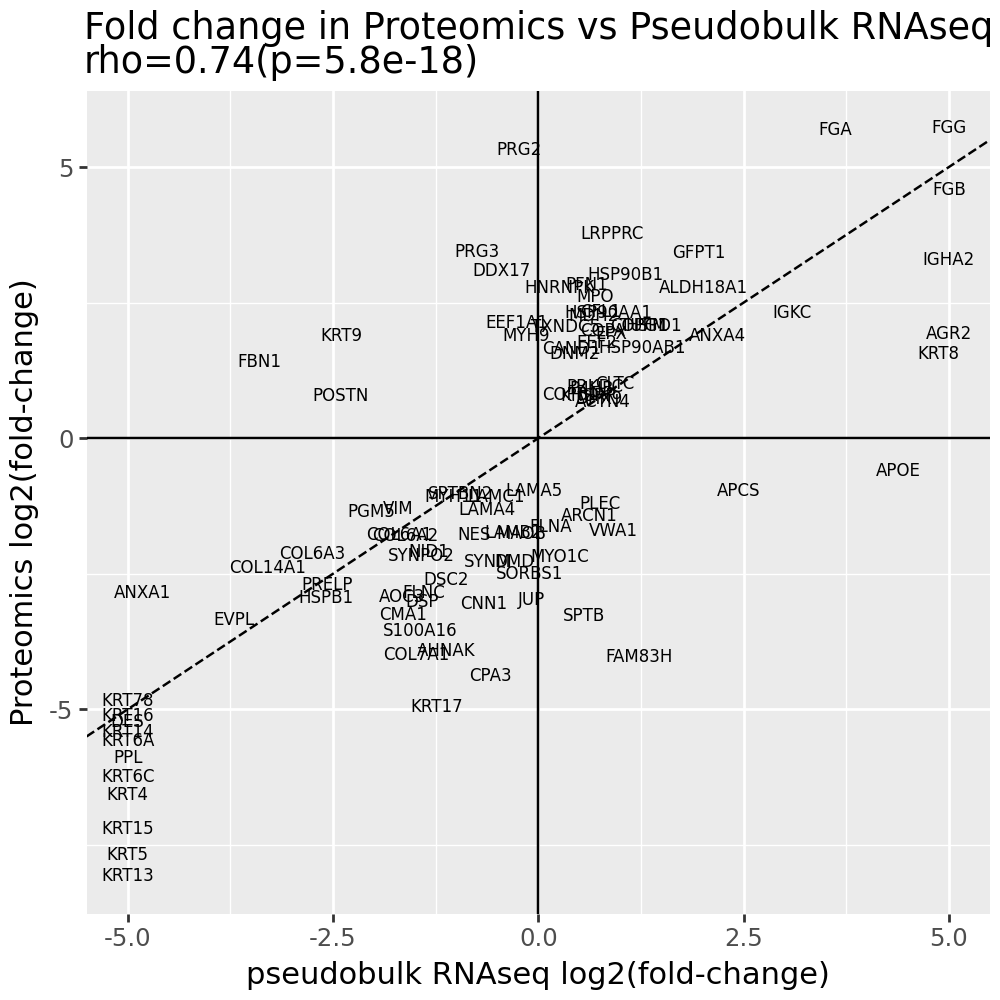

In [43]:
df = df_DE_diag_only.merge(df_NE_vs_T.set_index('gene'), left_index=True, right_index=True).loc[genes_up+genes_down]
p = plot_fc_comparision(df)+ pn.theme(figure_size=(5,5))
p.save(f'{plotfolder}/ECM_FC_comparison_unshrunk_diag.svg')
p

#### Diag, shrunk

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 5 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_FC_comparison_shrunk_diag.svg


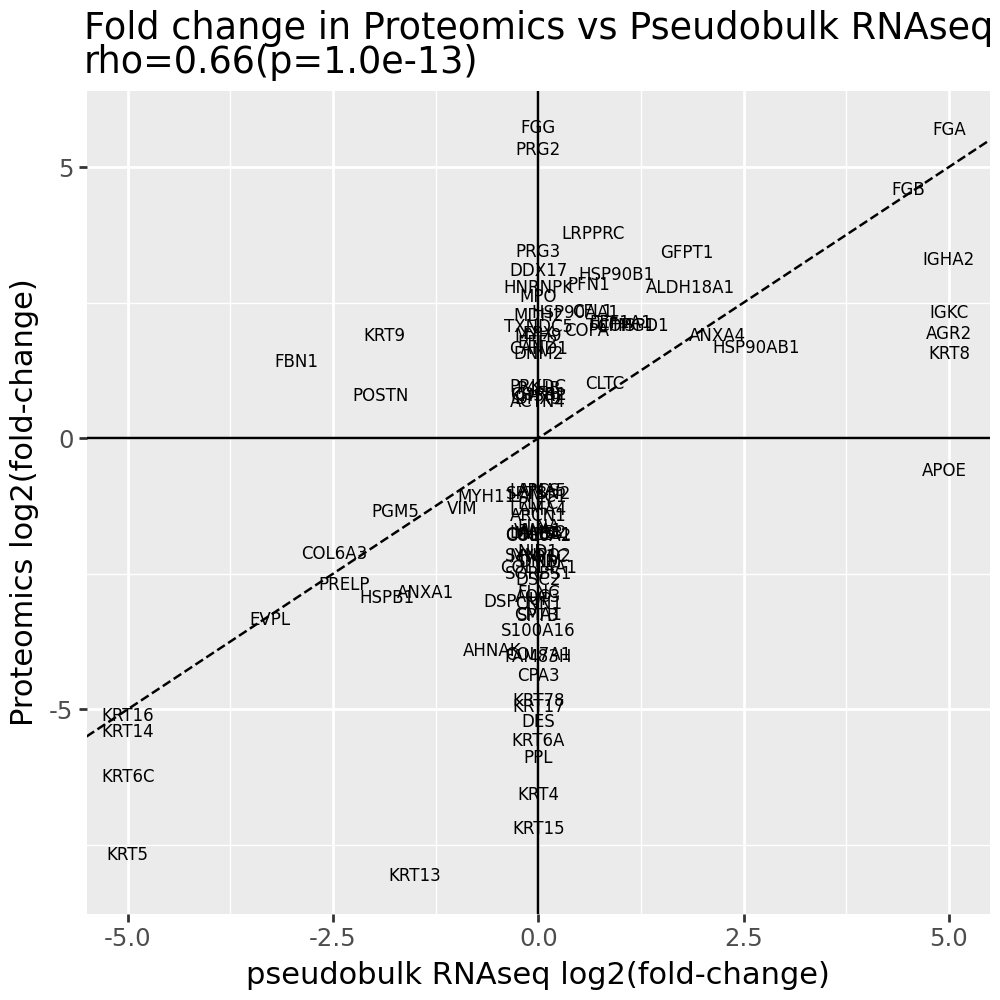

In [44]:
df = df_DE_diag_only_shrink.merge(df_NE_vs_T.set_index('gene'), left_index=True, right_index=True).loc[genes_up+genes_down]
p = plot_fc_comparision(df)+ pn.theme(figure_size=(5,5))
p.save(f'{plotfolder}/ECM_FC_comparison_shrunk_diag.svg')
p

# Fold change by cell type

In [45]:
from ecm_tools import suis_plot_fixed, ecm_lfc_via_deseq_python

In [46]:
# _new_df = suis_plot(genes_up)
_new_df = suis_plot_fixed(genes_up, A, diagnosis1="NE", diagnosis2="T")

_new_df['delta_expression_trim'] = _new_df['delta_expression'].apply(lambda x: np.clip(x, -20,20))
_new_df['min_cells'] =  _new_df.apply(lambda row: np.minimum(row['NE_ncells'], row['T_ncells']), axis=1)
_new_df['ratio_cells'] =  _new_df.apply(lambda row:  (1+row['T_ncells'])/(1+row['NE_ncells']), axis=1)
# _new_df['celltype_split'] = pd.Categorical(_new_df['celltype_split'], celltype_order_coarse_celltype)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:08<00:00,  5.00it/s]


In [47]:
_new_df_down = suis_plot_fixed(genes_down, A, diagnosis1="NE", diagnosis2="T")
_new_df_down['delta_expression_trim'] = _new_df_down['delta_expression'].apply(lambda x: np.clip(x, -20,20))
_new_df_down['min_cells'] =  _new_df_down.apply(lambda row: np.minimum(row['NE_ncells'], row['T_ncells']), axis=1)
_new_df_down['ratio_cells'] =  _new_df_down.apply(lambda row:  (1+row['T_ncells'])/(1+row['NE_ncells']), axis=1)
# _new_df['celltype_split'] = pd.Categorical(_new_df['celltype_split'], celltype_order_coarse_celltype)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:11<00:00,  4.66it/s]


In [48]:
colormap = pn.scale_color_manual(color_dict_coarse_celltype)
theme =  pn.theme(figure_size=(5,9), panel_background=pn.element_rect(fill='white', alpha=.2), line=pn.element_line(color='grey'))

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_FC_comparison_per_celltype_down_old.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 55 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 55 rows containing missing values.


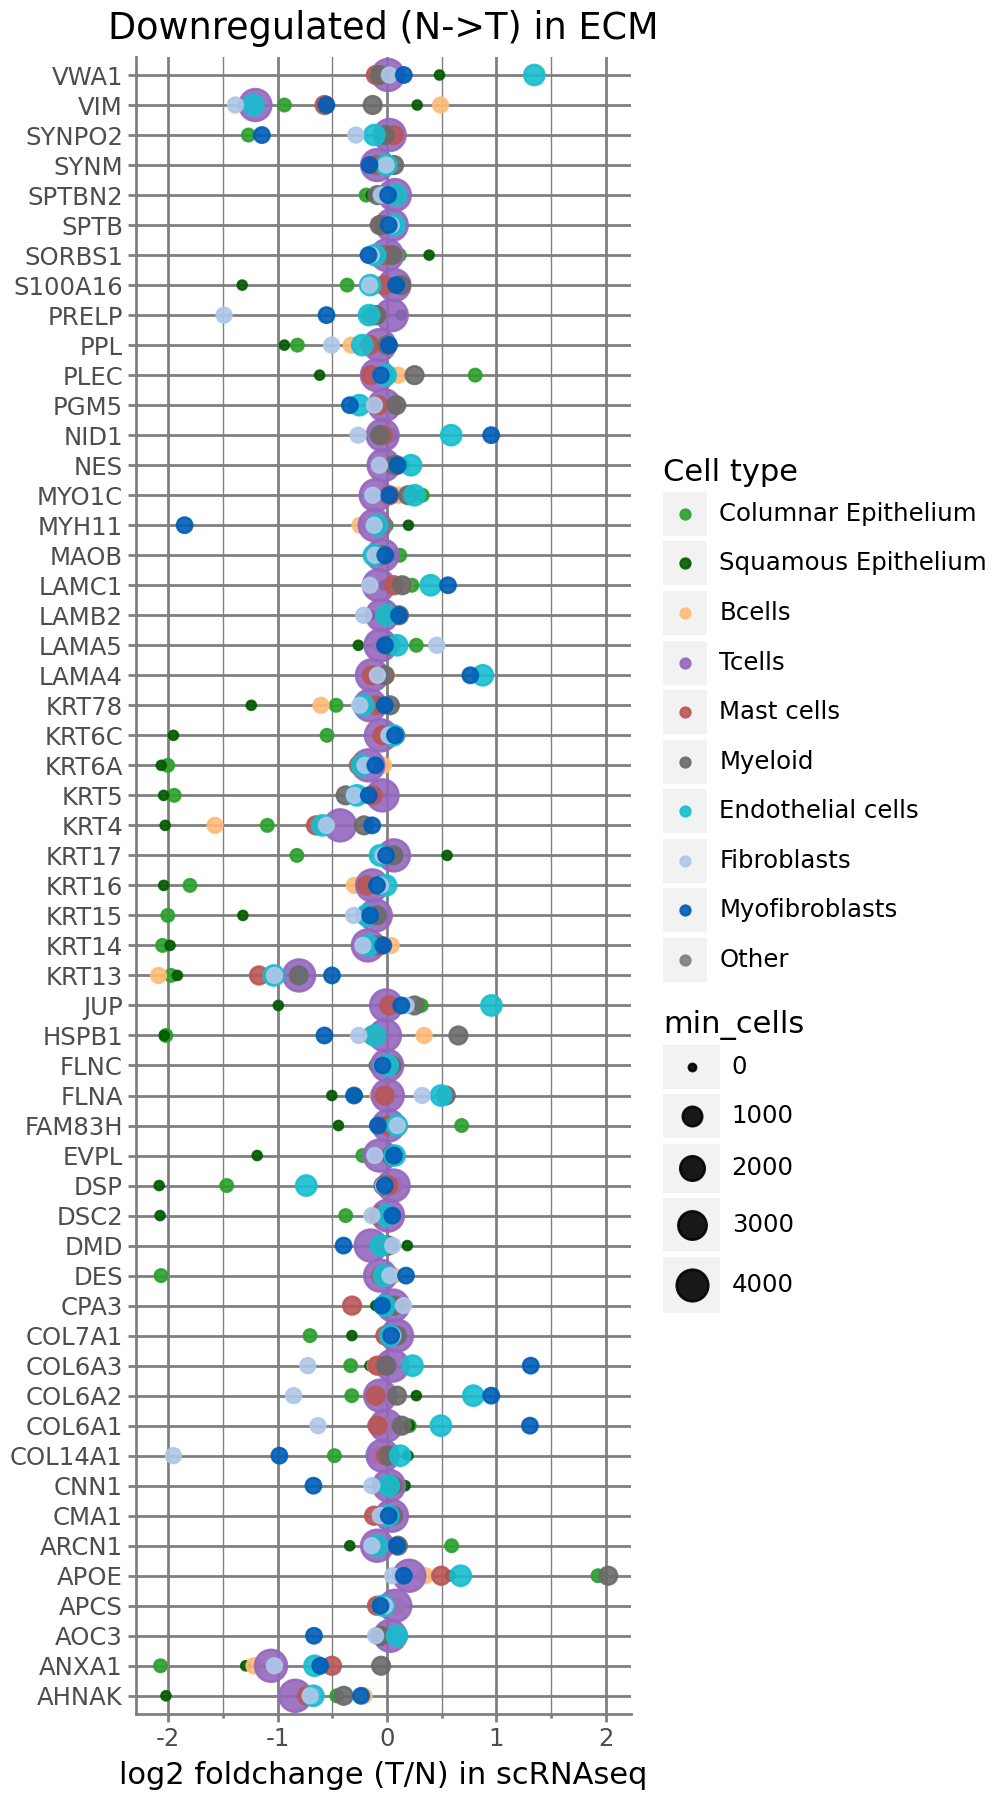

In [49]:
p = pn.ggplot(_new_df_down.merge(df_NE_vs_T, on='gene').rename({'celltype_split': 'Cell type'}, axis=1),   #'np.log10(min_cells)')
          pn.aes(y='gene', x='np.clip(np.log2(ratio), -2,2)', color='Cell type',size='min_cells')) \
+ pn.geom_jitter(alpha=0.9,height=0, width=0.1 ) + colormap\
+ pn.labs(x='log2 foldchange (T/N) in scRNAseq', title='Downregulated (N->T) in ECM', y='') \
+ theme
p.save(f'{plotfolder}/ECM_FC_comparison_per_celltype_down_old.svg')
p

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_FC_comparison_per_celltype_up_old.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 43 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 43 rows containing missing values.


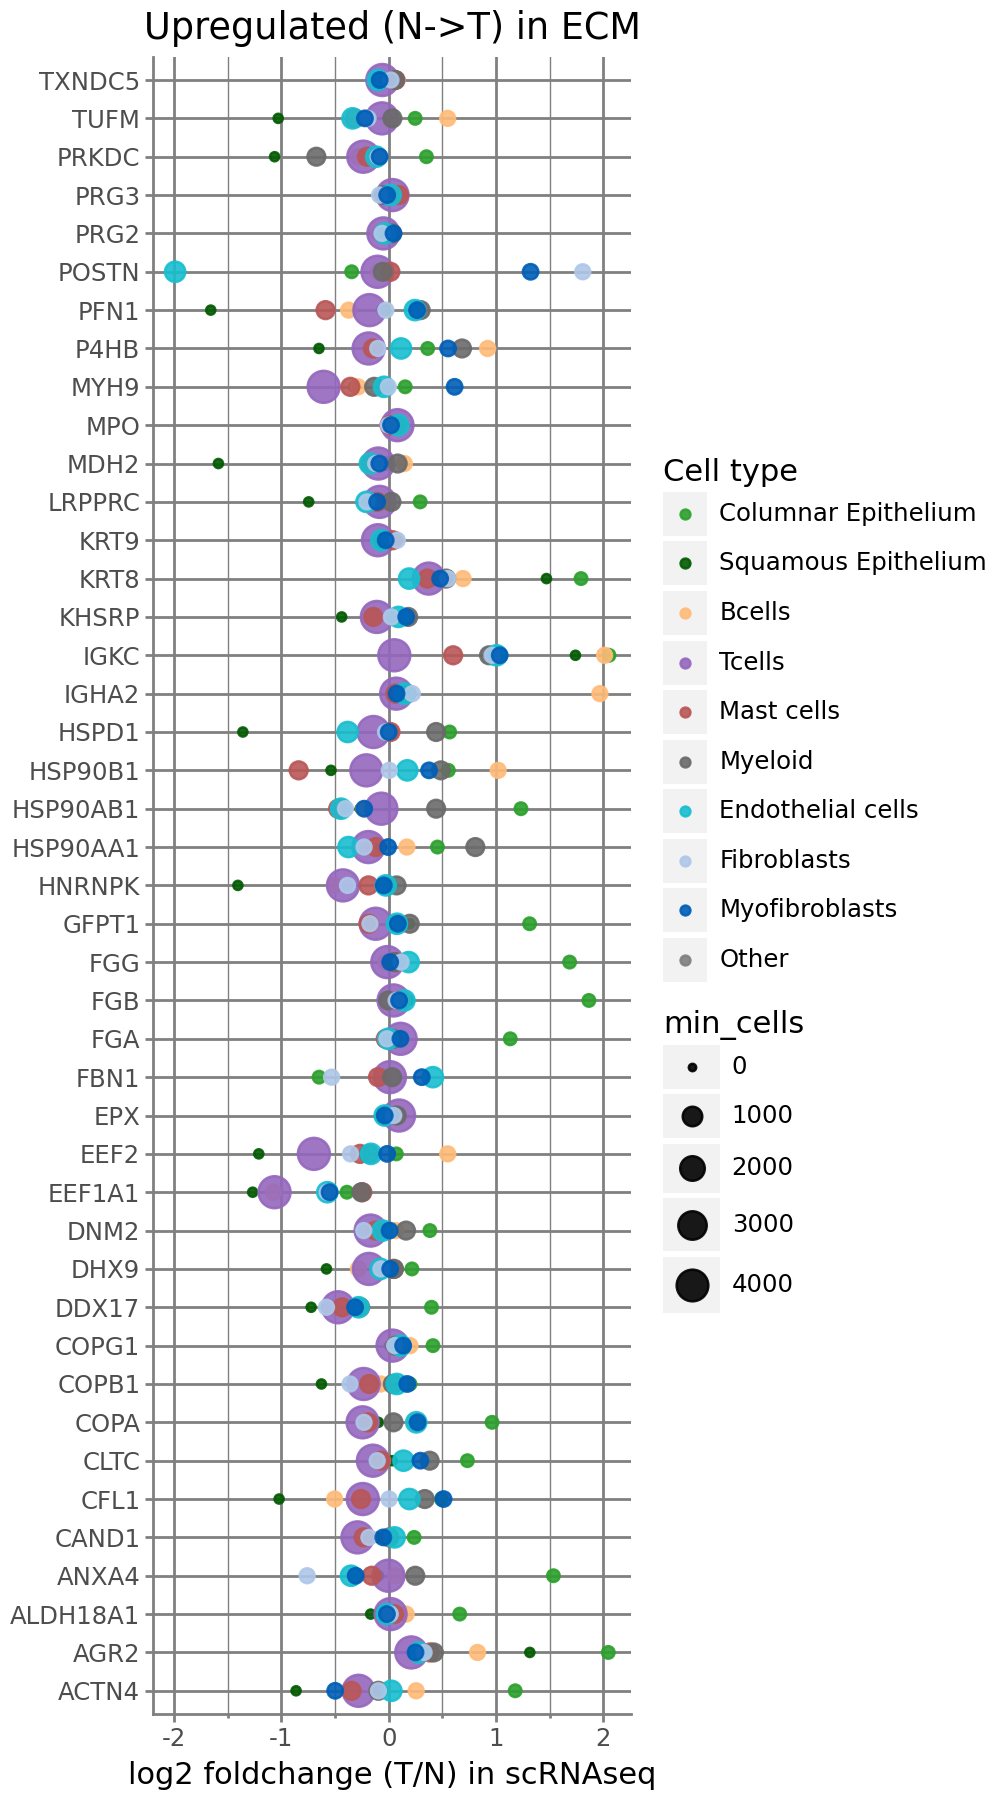

In [50]:
p = pn.ggplot(_new_df.merge(df_NE_vs_T, on='gene').rename({'celltype_split': 'Cell type'}, axis=1),   #'np.log10(min_cells)')
          pn.aes(y='gene', x='np.clip(np.log2(ratio), -2,2)', color='Cell type',size='min_cells')) \
+ pn.geom_jitter(alpha=0.9,height=0, width=0.1 ) + colormap\
+ pn.labs(x='log2 foldchange (T/N) in scRNAseq', title='Upregulated (N->T) in ECM', y='') \
+ theme
p.save(f'{plotfolder}/ECM_FC_comparison_per_celltype_up_old.svg')
p

## naive

In [51]:
from ecm_tools import suis_plot_fixed

In [52]:
_new_df = suis_plot_fixed(genes_up, A, diagnosis1="NE", diagnosis2="T")
_new_df['delta_expression_trim'] = _new_df['delta_expression'].apply(lambda x: np.clip(x, -20,20))
_new_df['min_cells'] =  _new_df.apply(lambda row: np.minimum(row['NE_ncells'], row['T_ncells']), axis=1)
_new_df['ratio_cells'] =  _new_df.apply(lambda row:  (1+row['T_ncells'])/(1+row['NE_ncells']), axis=1)
# _new_df['celltype_split'] = pd.Categorical(_new_df['celltype_split'], celltype_order_coarse_celltype)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:12<00:00,  3.38it/s]


In [53]:
_new_df_down = suis_plot_fixed(genes_down, A, diagnosis1="NE", diagnosis2="T")
_new_df_down['delta_expression_trim'] = _new_df_down['delta_expression'].apply(lambda x: np.clip(x, -20,20))
_new_df_down['min_cells'] =  _new_df_down.apply(lambda row: np.minimum(row['NE_ncells'], row['T_ncells']), axis=1)
_new_df_down['ratio_cells'] =  _new_df_down.apply(lambda row:  (1+row['T_ncells'])/(1+row['NE_ncells']), axis=1)
# _new_df['celltype_split'] = pd.Categorical(_new_df['celltype_split'], celltype_order_coarse_celltype)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:12<00:00,  4.53it/s]


In [54]:
# colormap = pn.scale_color_brewer(type='qual', palette="Paired", name='Cell type') 
colormap = pn.scale_color_manual(color_dict_coarse_celltype)
theme =  pn.theme(figure_size=(5,9), panel_background=pn.element_rect(fill='white', alpha=.2), line=pn.element_line(color='grey'))

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_FC_comparison_per_celltype_down.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 55 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 55 rows containing missing values.


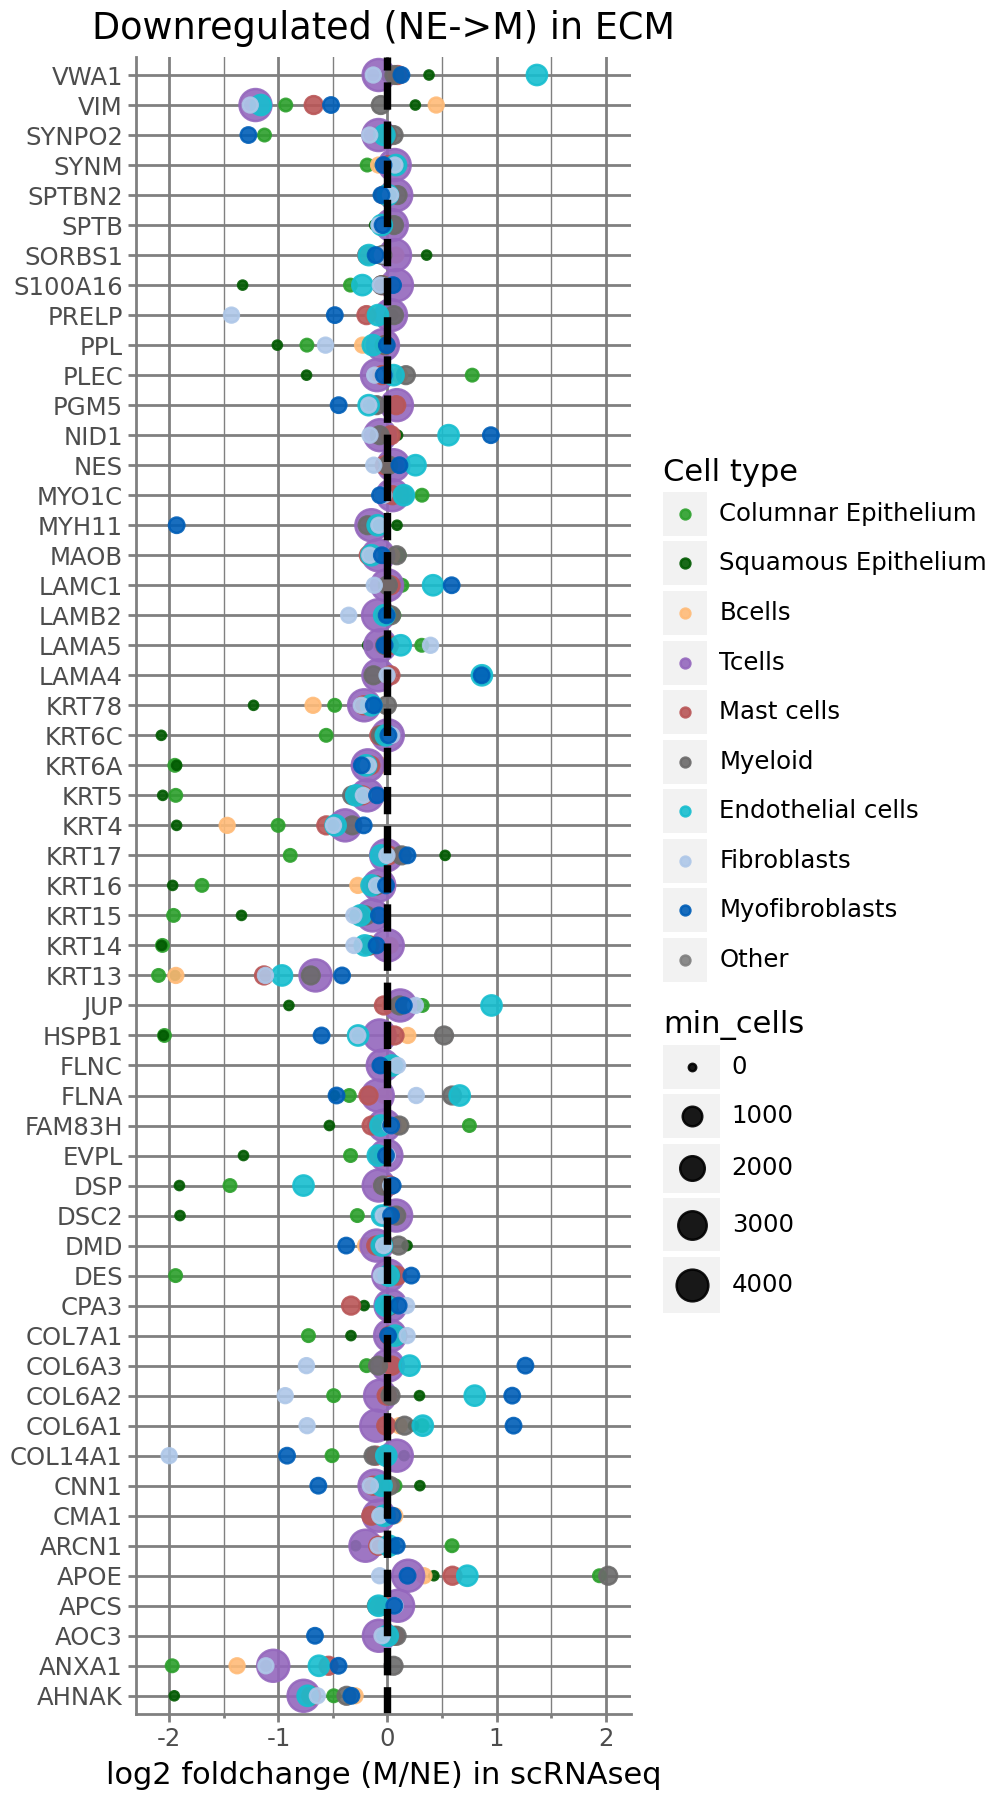

In [55]:
p = pn.ggplot(_new_df_down.merge(df_NE_vs_T, on='gene').rename({'celltype_split': 'Cell type'}, axis=1),   #'np.log10(min_cells)')
          pn.aes(y='gene', x='np.clip(np.log2(ratio), -2,2)', color='Cell type',size='min_cells')) \
+ pn.geom_jitter(alpha=0.9,height=0, width=0.1 ) + colormap + pn.geom_vline(xintercept=0, size=1.5, linetype="dashed") \
+ pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Downregulated (NE->M) in ECM', y='') \
+ theme
p.save(f'{plotfolder}/ECM_FC_comparison_per_celltype_down.svg')
p

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_FC_comparison_per_celltype_up.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 43 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 43 rows containing missing values.


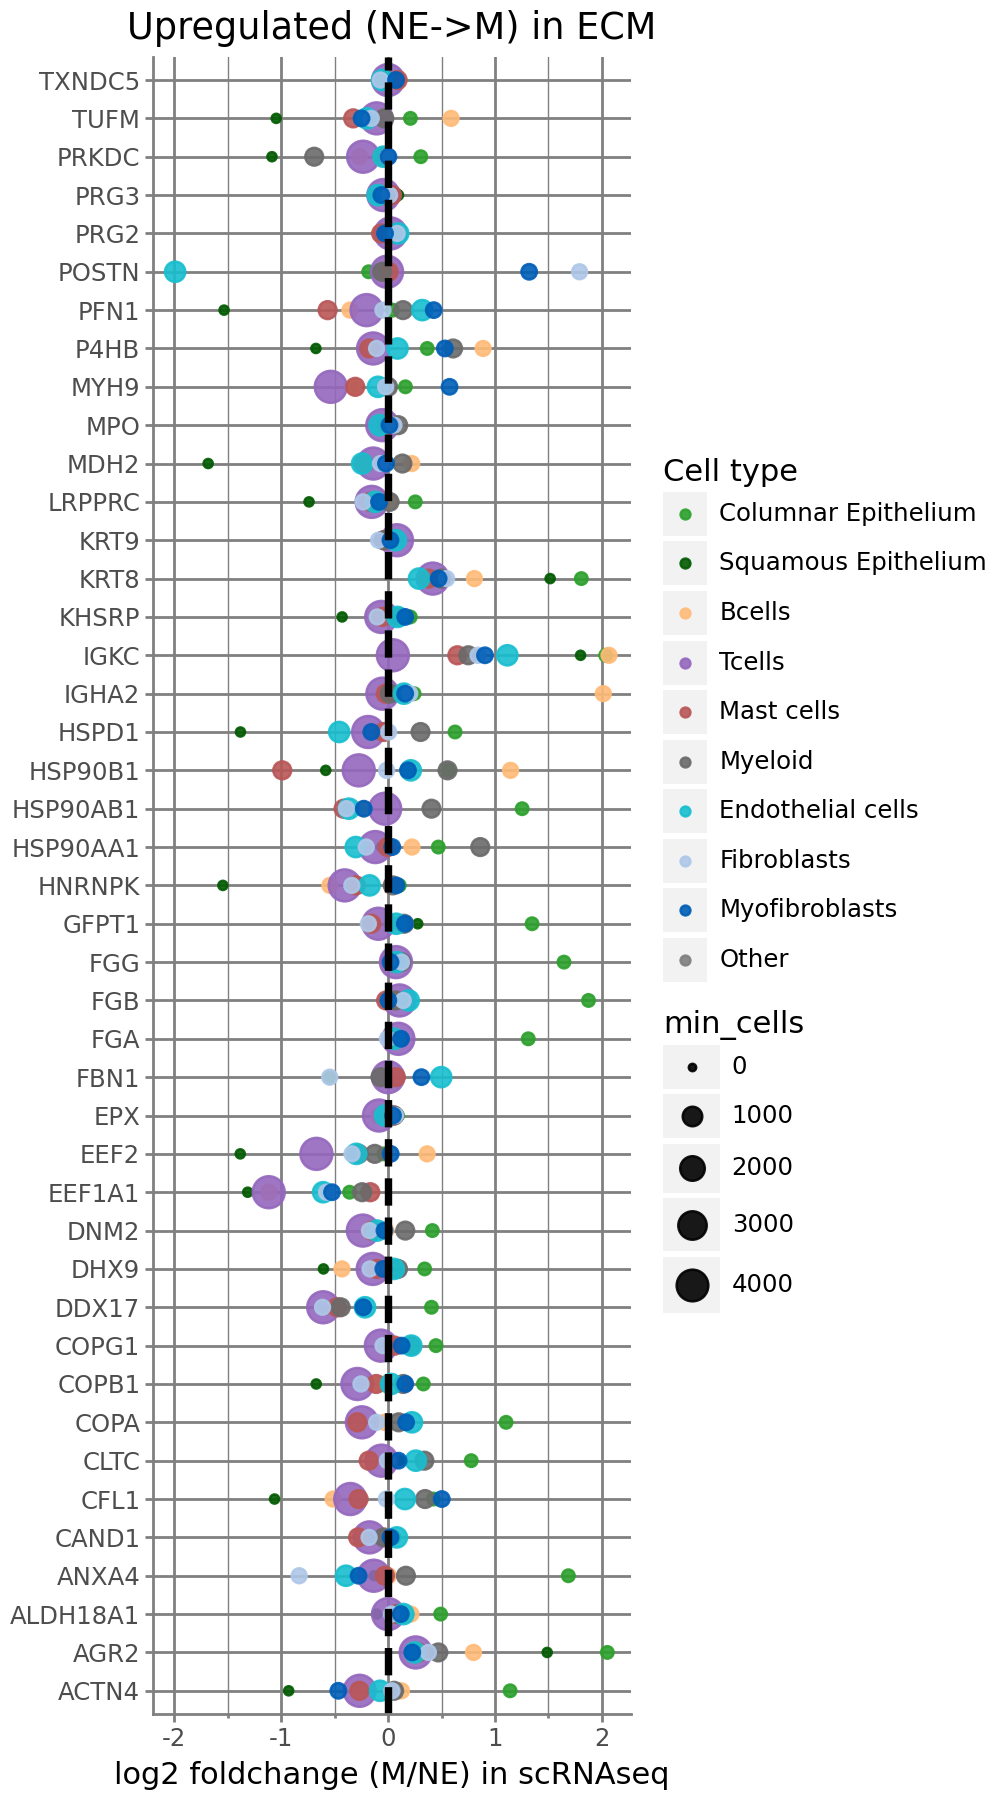

In [56]:
p = pn.ggplot(_new_df.merge(df_NE_vs_T, on='gene').rename({'celltype_split': 'Cell type'}, axis=1),   #'np.log10(min_cells)')
          pn.aes(y='gene', x='np.clip(np.log2(ratio), -2,2)', color='Cell type',size='min_cells')) \
+ pn.geom_jitter(alpha=0.9,height=0, width=0.1 ) + colormap+ pn.geom_vline(xintercept=0, size=1.5, linetype="dashed") \
+ pn.labs(x='log2 foldchange (M/NE) in scRNAseq', title='Upregulated (NE->M) in ECM', y='') \
+ theme
p.save(f'{plotfolder}/ECM_FC_comparison_per_celltype_up.svg')

p

## DEseq fold changes

In [57]:
from sctools.deseq import DESeq2_pseudobulk_wrapper, plot_pca_grid, covariate_pc_correlation

In [58]:
from ecm_tools import ecm_lfc_via_deseq_python, the_plot_shrunk, the_plot_unshrunk

In [59]:
A.obs['celltype_merge_epi']=A.obs['celltype_split'].astype(str)
A.obs['celltype_merge_epi'].replace({'Columnar Epithelium': 'Epithelium','Squamous Epithelium': "Epithelium"}, inplace=True)

### ~patient + diag

In [60]:
contrast = ["diagnosis",  "NE", "T"]
design_factors = ['patient','diagnosis']
df_de_all, adata_vsds =  ecm_lfc_via_deseq_python(A, design_factors, contrast=contrast, gene_min_counts=10)
df_de_all['independent_filter'] = df_de_all.padj.apply(lambda x: 'filtered' if np.isnan(x) else 'ok')

Celltype: Myeloid


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.92 seconds.

Fitting dispersion trend curve...
... done in 0.38 seconds.

Fitting MAP dispersions...
... done in 2.42 seconds.

Fitting LFCs...
... done in 2.69 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.65 seconds.



Celltype: Fibroblasts


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.64 seconds.

Fitting dispersion trend curve...
... done in 0.90 seconds.

Fitting MAP dispersions...
... done in 2.57 seconds.

Fitting LFCs...
... done in 2.68 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.60 seconds.



Celltype: Bcells


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.25 seconds.

Fitting dispersion trend curve...
... done in 0.42 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
Fitting MAP dispersions...
... done in 2.45 seconds.

Fitting LFCs...
... done in 2.07 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.52 seconds.



Celltype: Epithelium


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.39 seconds.

Fitting dispersion trend curve...
... done in 0.70 seconds.

Fitting MAP dispersions...
... done in 3.71 seconds.

Fitting LFCs...
... done in 3.30 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.99 seconds.



Celltype: Myofibroblasts


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.33 seconds.

Fitting dispersion trend curve...
... done in 0.32 seconds.

/opt/conda/lib/python3.11/site-packages/pydeseq2/dds.py:497: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
Fitting MAP dispersions...
... done in 2.00 seconds.

Fitting LFCs...
... done in 2.45 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.16 seconds.



Celltype: Tcells


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 1.66 seconds.

Fitting dispersion trend curve...
... done in 0.39 seconds.

Fitting MAP dispersions...
... done in 2.26 seconds.

Fitting LFCs...
... done in 2.07 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.41 seconds.



Celltype: Endothelial cells


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.17 seconds.

Fitting dispersion trend curve...
... done in 0.43 seconds.

Fitting MAP dispersions...
... done in 2.34 seconds.

Fitting LFCs...
... done in 2.24 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.55 seconds.



Celltype: Mast cells


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.16 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 1.73 seconds.

Fitting LFCs...
... done in 1.86 seconds.

Calculating cook's distance...
... done in 0.01 seconds.

Replacing 0 outlier genes.



Fit type used for VST : parametric


Fitting dispersions...
... done in 1.10 seconds.



Celltype: Other


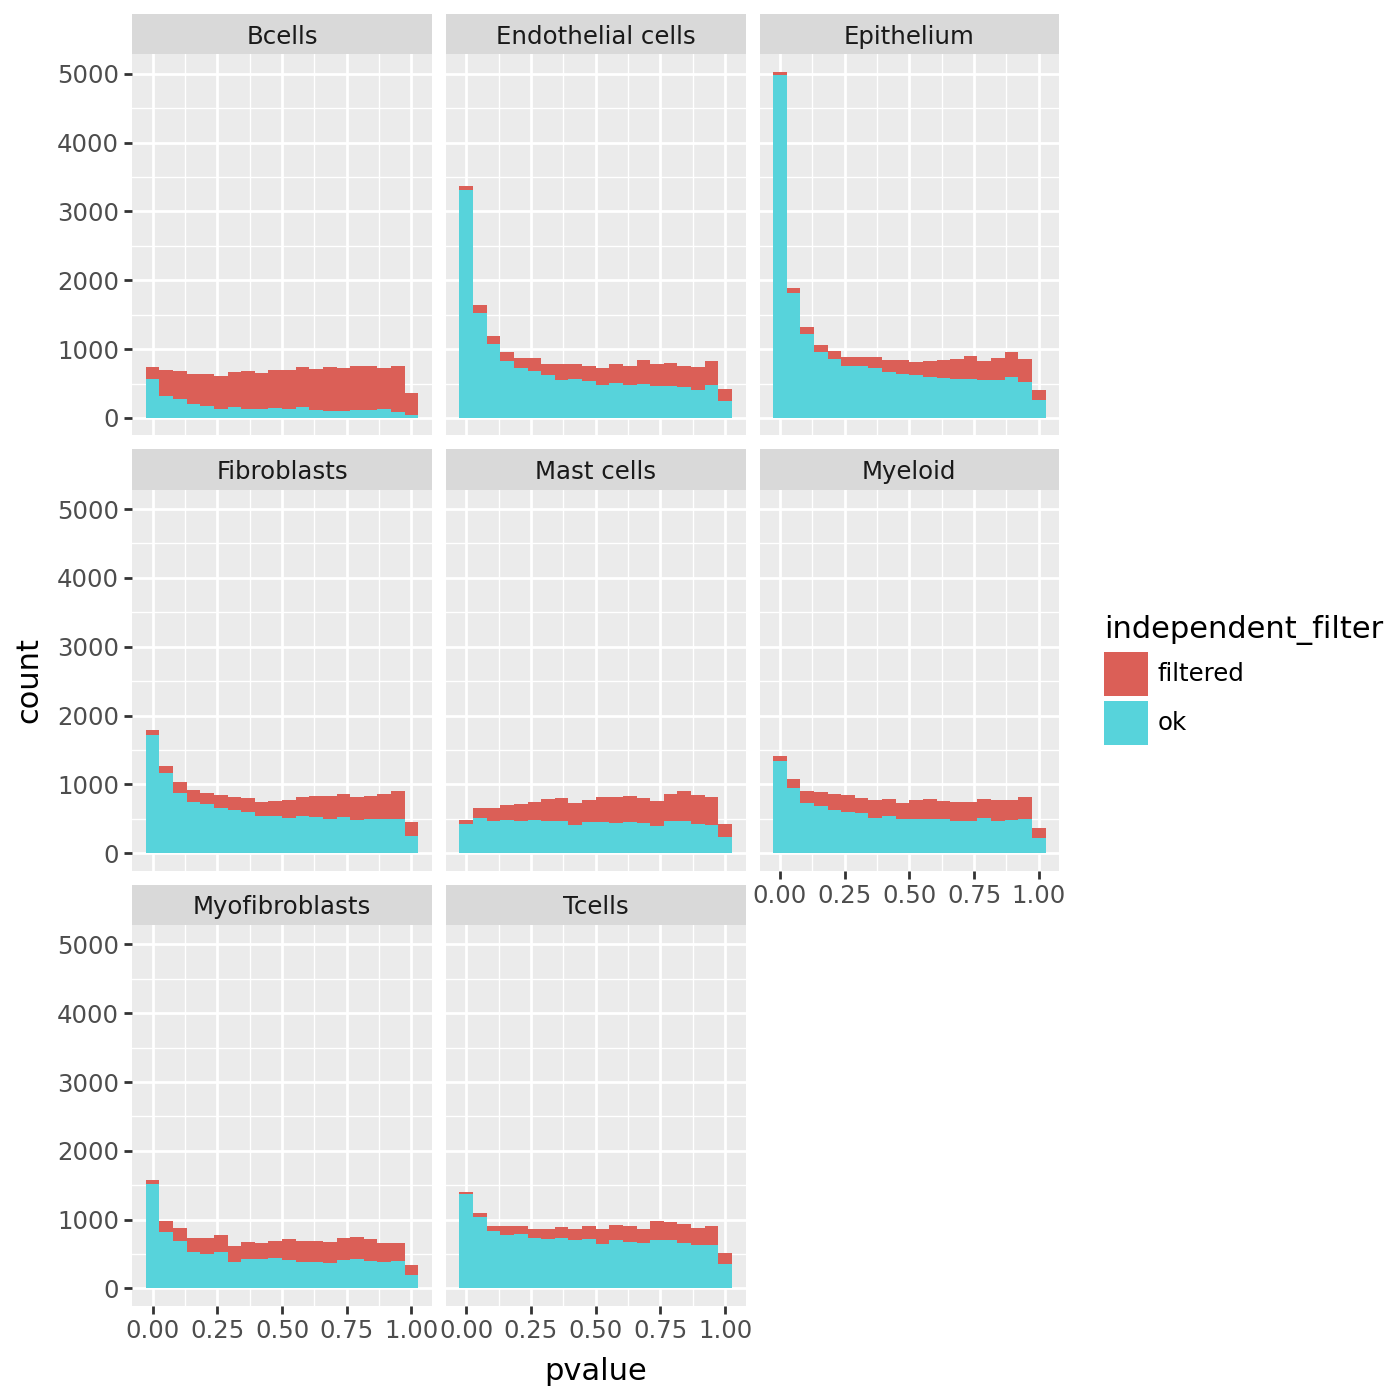

In [61]:
pn.ggplot(df_de_all, pn.aes('pvalue', fill='independent_filter')) + pn.geom_histogram(bins=20) + pn.facet_wrap('celltype') +  pn.theme(figure_size=(7,7))

#### shrunk

/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 97 rows containing missing values.


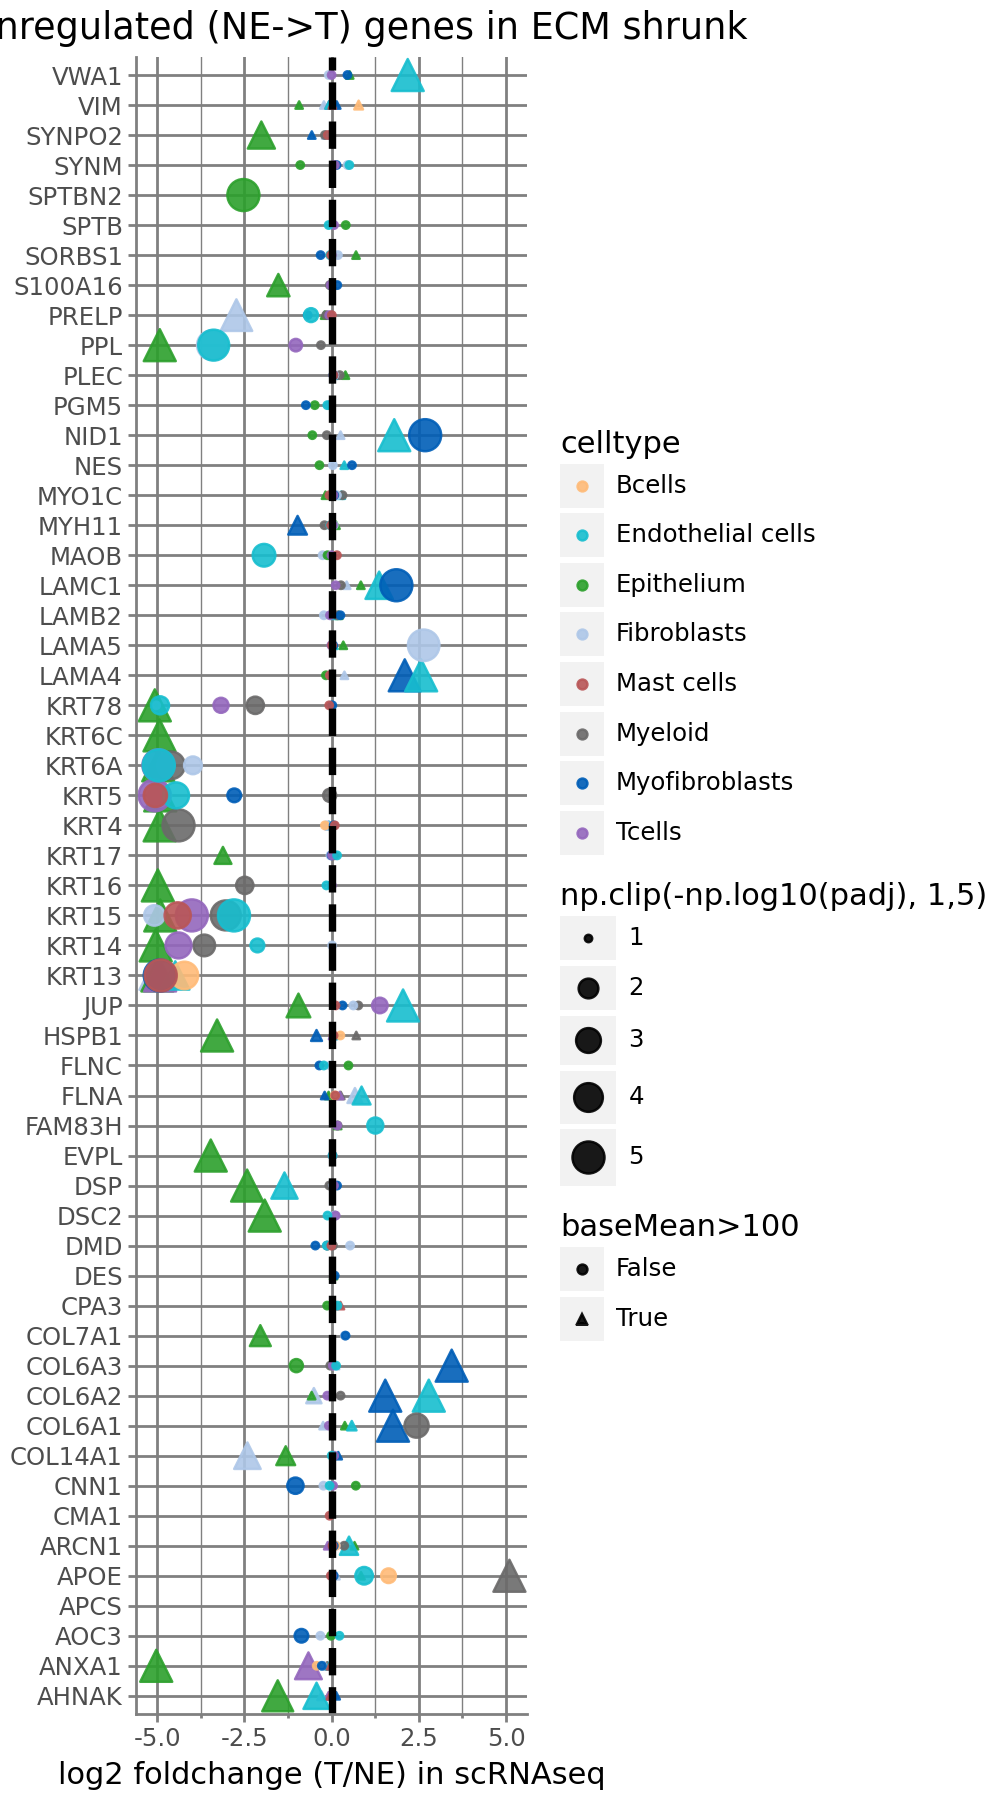

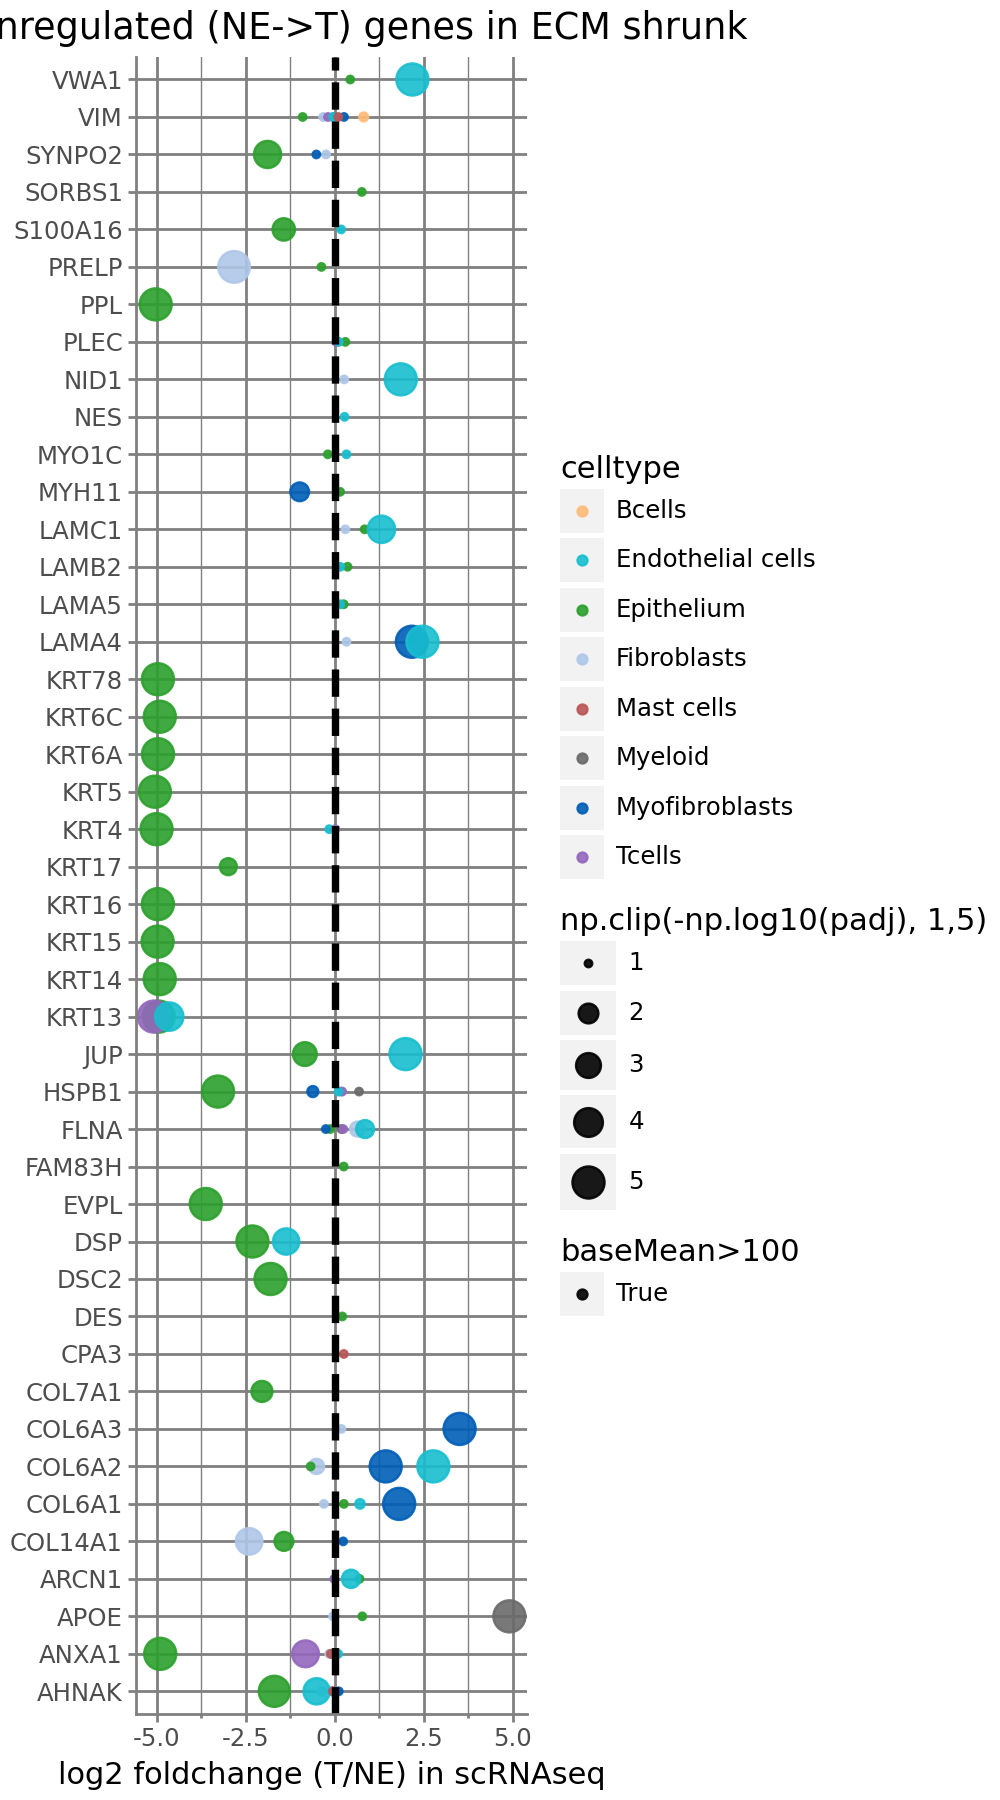

(None, None)

In [62]:
p = the_plot_shrunk(df_de_all.loc[[_ for _ in genes_down if _ in  df_de_all.index]].reset_index()) + pn.labs(x='log2 foldchange (T/NE) in scRNAseq', title='Downregulated (NE->T) genes in ECM shrunk', y='')
p2 = the_plot_shrunk(df_de_all.loc[[_ for _ in genes_down if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (T/NE) in scRNAseq', title='Downregulated (NE->T) genes in ECM shrunk', y='')
p.show(), p2.show()

/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 31 rows containing missing values.


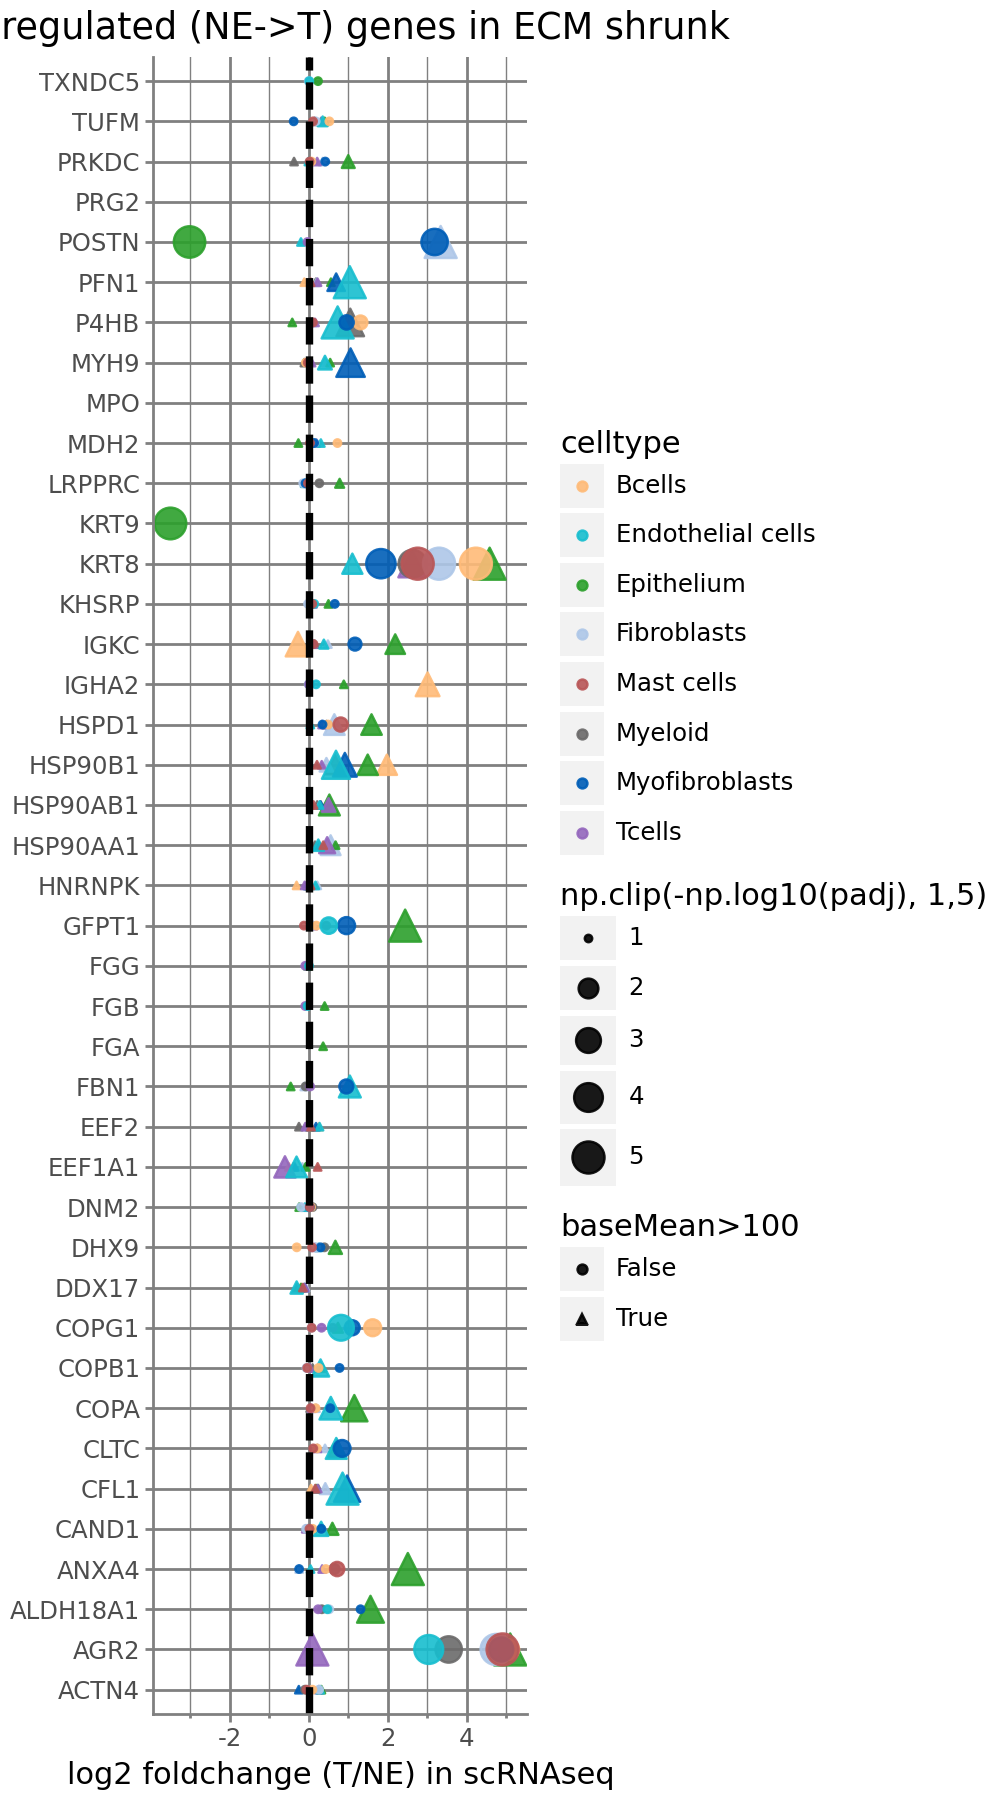

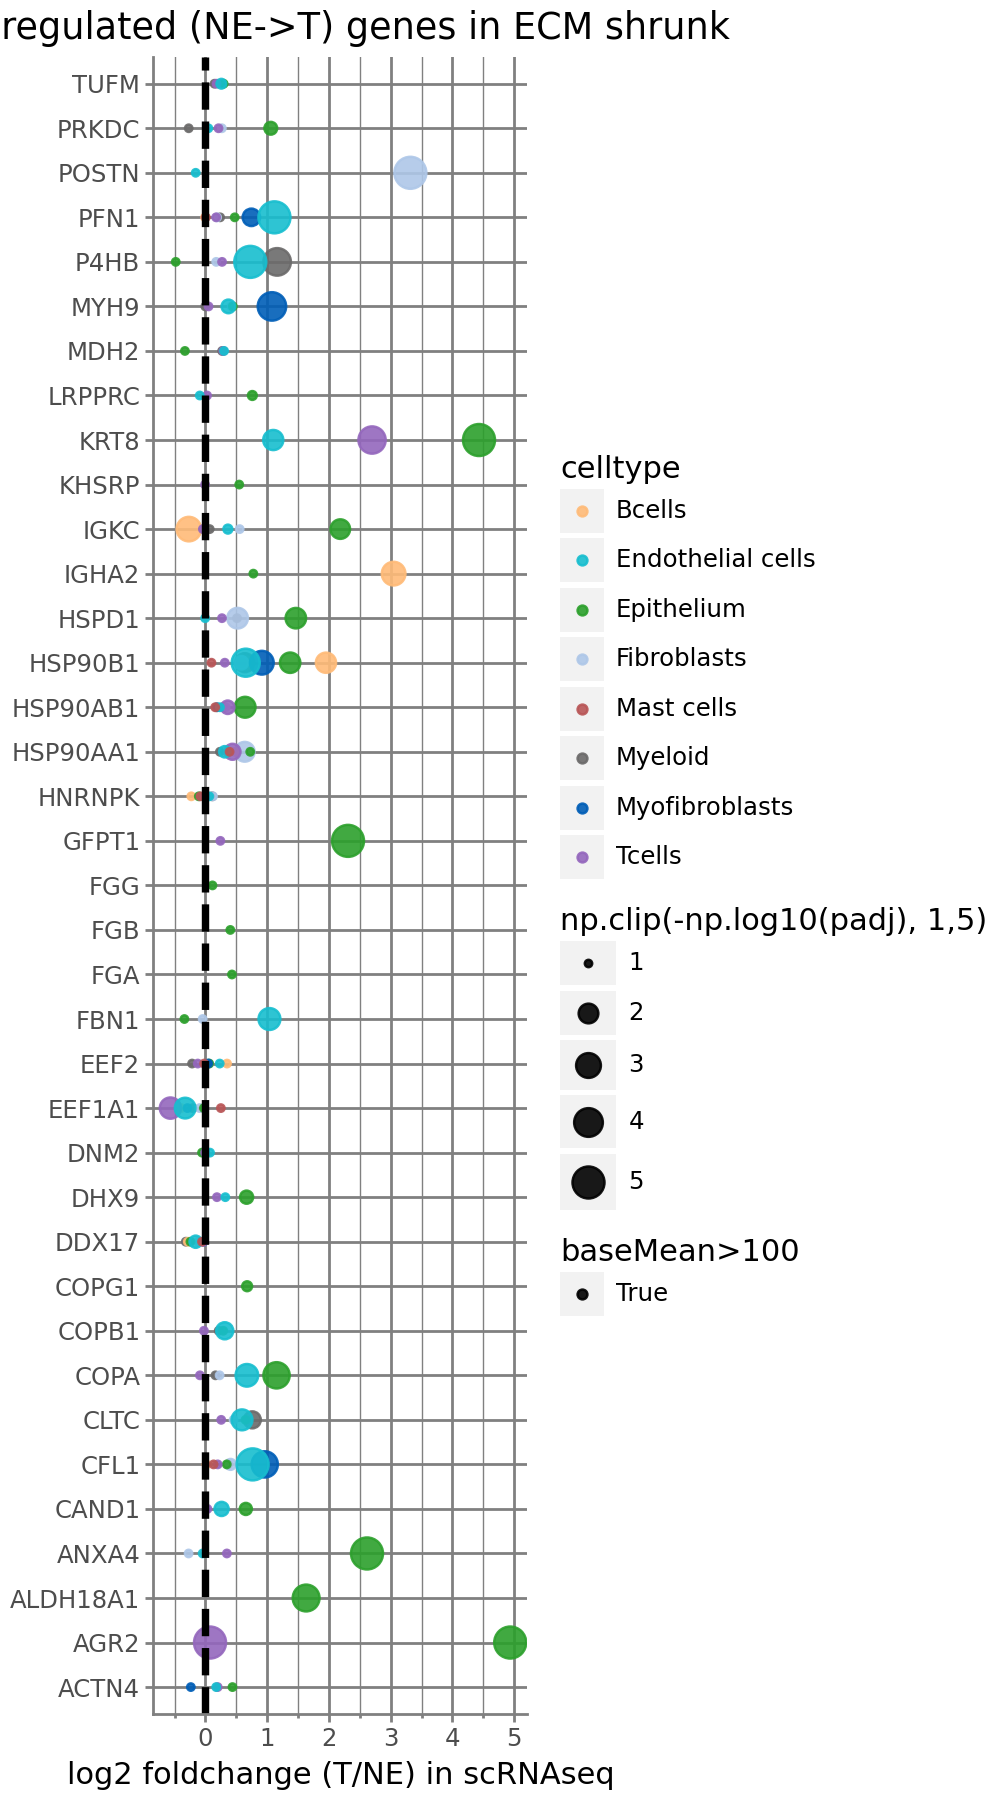

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_DESeq_FC_per_celltype_up_patient_diag.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 31 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_DESeq_FC_per_celltype_up_patient_diag_baseMean.svg


(<plotnine.ggplot.ggplot at 0x7f1bc84f2ed0>,
 <plotnine.ggplot.ggplot at 0x7f1bc84f1e50>)

In [63]:
p = the_plot_shrunk(df_de_all.loc[[_ for _ in genes_up if _ in  df_de_all.index]].reset_index()) + pn.labs(x='log2 foldchange (T/NE) in scRNAseq', title='Upregulated (NE->T) genes in ECM shrunk', y='')
p2 = the_plot_shrunk(df_de_all.loc[[_ for _ in genes_up if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (T/NE) in scRNAseq', title='Upregulated (NE->T) genes in ECM shrunk', y='')
p.show(), p2.show()

p.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_patient_diag.svg')
p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_patient_diag_baseMean.svg')

p, p2

#### unshrunk

/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 31 rows containing missing values.


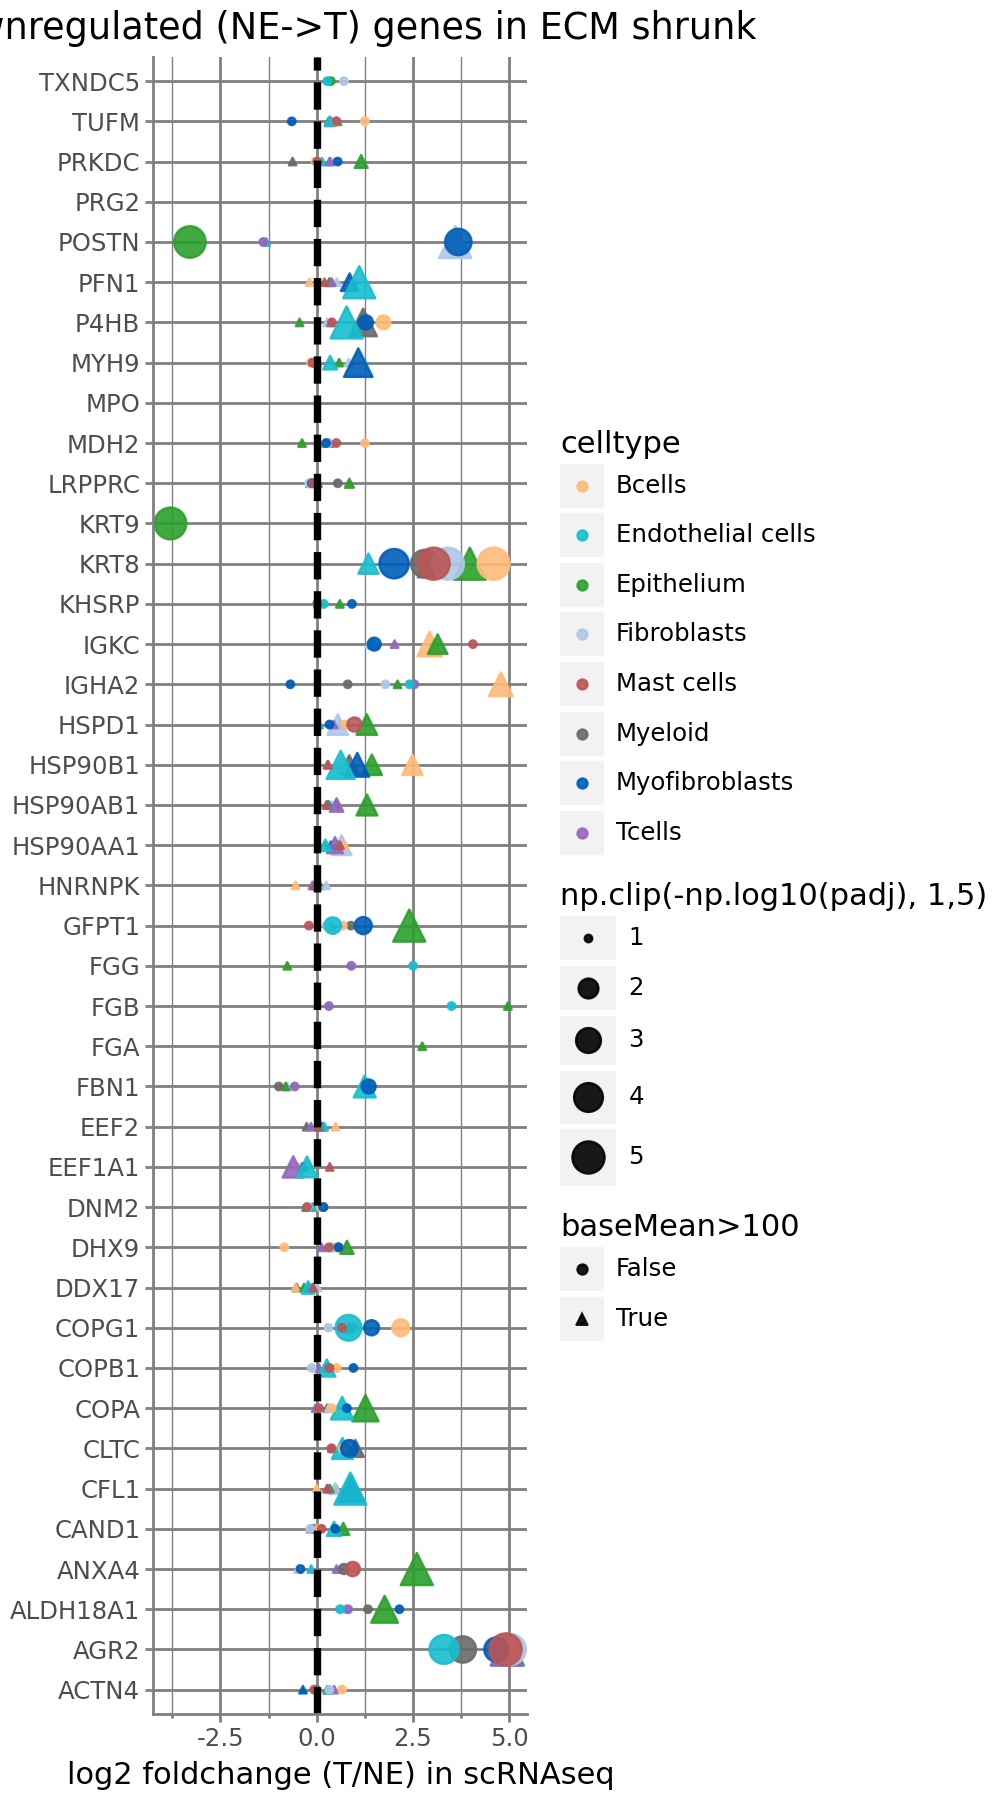

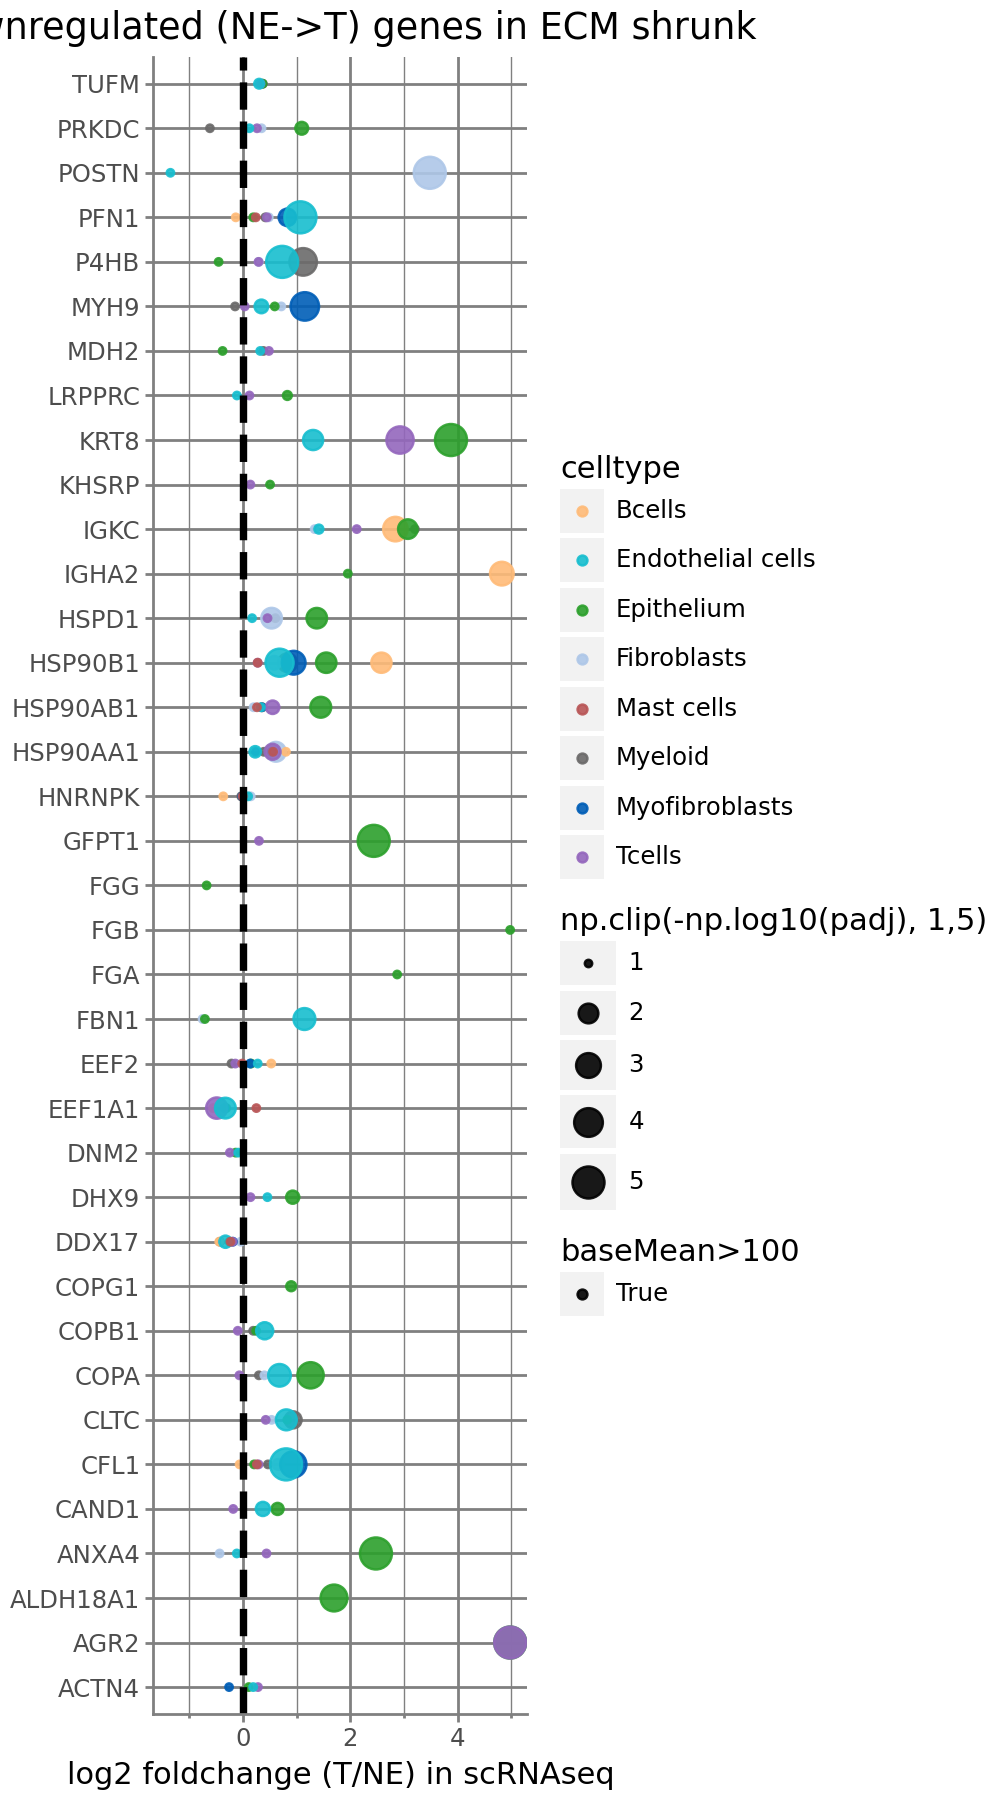

/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk.svg
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 31 rows containing missing values.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 5 x 9 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: /tmp/ECM_NE_vs_T/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk.svg


(<plotnine.ggplot.ggplot at 0x7f1bd07a31d0>,
 <plotnine.ggplot.ggplot at 0x7f1dc4258e10>)

In [64]:
p = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_up if _ in  df_de_all.index]].reset_index()) + pn.labs(x='log2 foldchange (T/NE) in scRNAseq', title='Downregulated (NE->T) genes in ECM shrunk', y='')
p2 = the_plot_unshrunk(df_de_all.loc[[_ for _ in genes_up if _ in  df_de_all.index]].reset_index().query("baseMean>100")) + pn.labs(x='log2 foldchange (T/NE) in scRNAseq', title='Downregulated (NE->T) genes in ECM shrunk', y='')
p.show(), p2.show()

p.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk.svg')
p2.save(f'{plotfolder}/ECM_DESeq_FC_per_celltype_up_patient_diag_unshrunk.svg')

p, p2

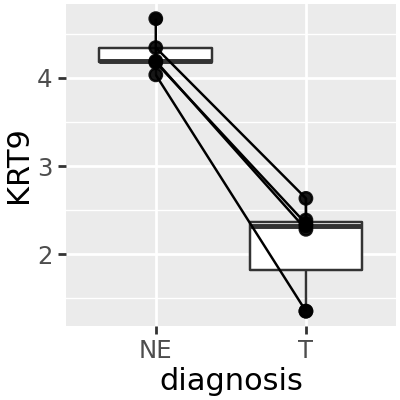

In [65]:
vsd = adata_vsds['Epithelium'].copy()
plot_gene('KRT9', vsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))

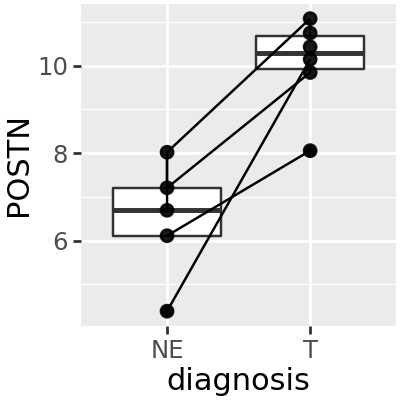

In [66]:
vsd = adata_vsds['Fibroblasts'].copy()
plot_gene('POSTN', vsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))

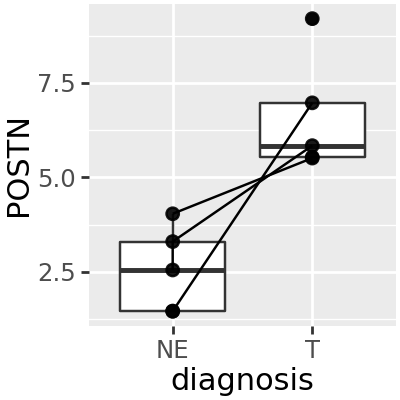

In [67]:
vsd = adata_vsds['Myofibroblasts'].copy()
plot_gene('POSTN', vsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))

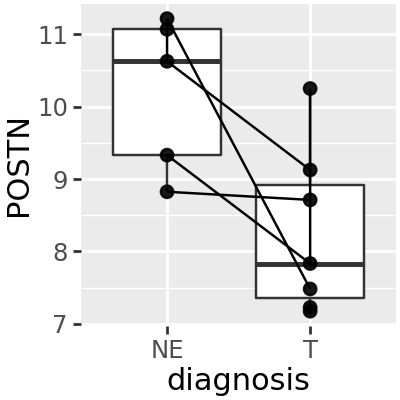

In [68]:
vsd = adata_vsds['Endothelial cells'].copy()
plot_gene('POSTN', vsd, grouping_var='diagnosis') + pn.theme(figure_size=(2,2))